# Benchmarking other clustering techniques against Function Enconding Units Pipeline

In [1]:
import torch
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import ConnectionPatch
import math
import numpy as np
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import euclidean_distances

from scipy.optimize import linear_sum_assignment

import cebra

import warnings

plt.style.use('./ssass.mplstyle')

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [3]:
def eval_clusters(true, pred, calc_acc=True):
    """ Evaluate clustering performance using NMI, ARI, and ACC.
    
    Args: 
        true (np.array): true cluster labels
        pred (np.array): predicted cluster labels
        calc_acc (bool): whether to calculate accuracy

    Returns:
        nmi (float): normalized mutual information
        ari (float): adjusted rand index
        acc (float): accuracy
    """
    nmi = normalized_mutual_info_score(true, pred)
    ari = adjusted_rand_score(true, pred)
    
    if calc_acc:
        cm = confusion_matrix(true, pred)
        _, true_perm = linear_sum_assignment(-cm)
        true_permed = np.array([true_perm[x] for x in true])
        acc = np.mean(pred == true_permed)
        
        return nmi, ari, acc

In [4]:
# create a dataframe to store the results
results = pd.DataFrame(columns=['technique', 'nmi_mean', 'nmi_std', 'ari_mean', 'ari_std', 'acc_mean', 'acc_std'])

## KMEANS

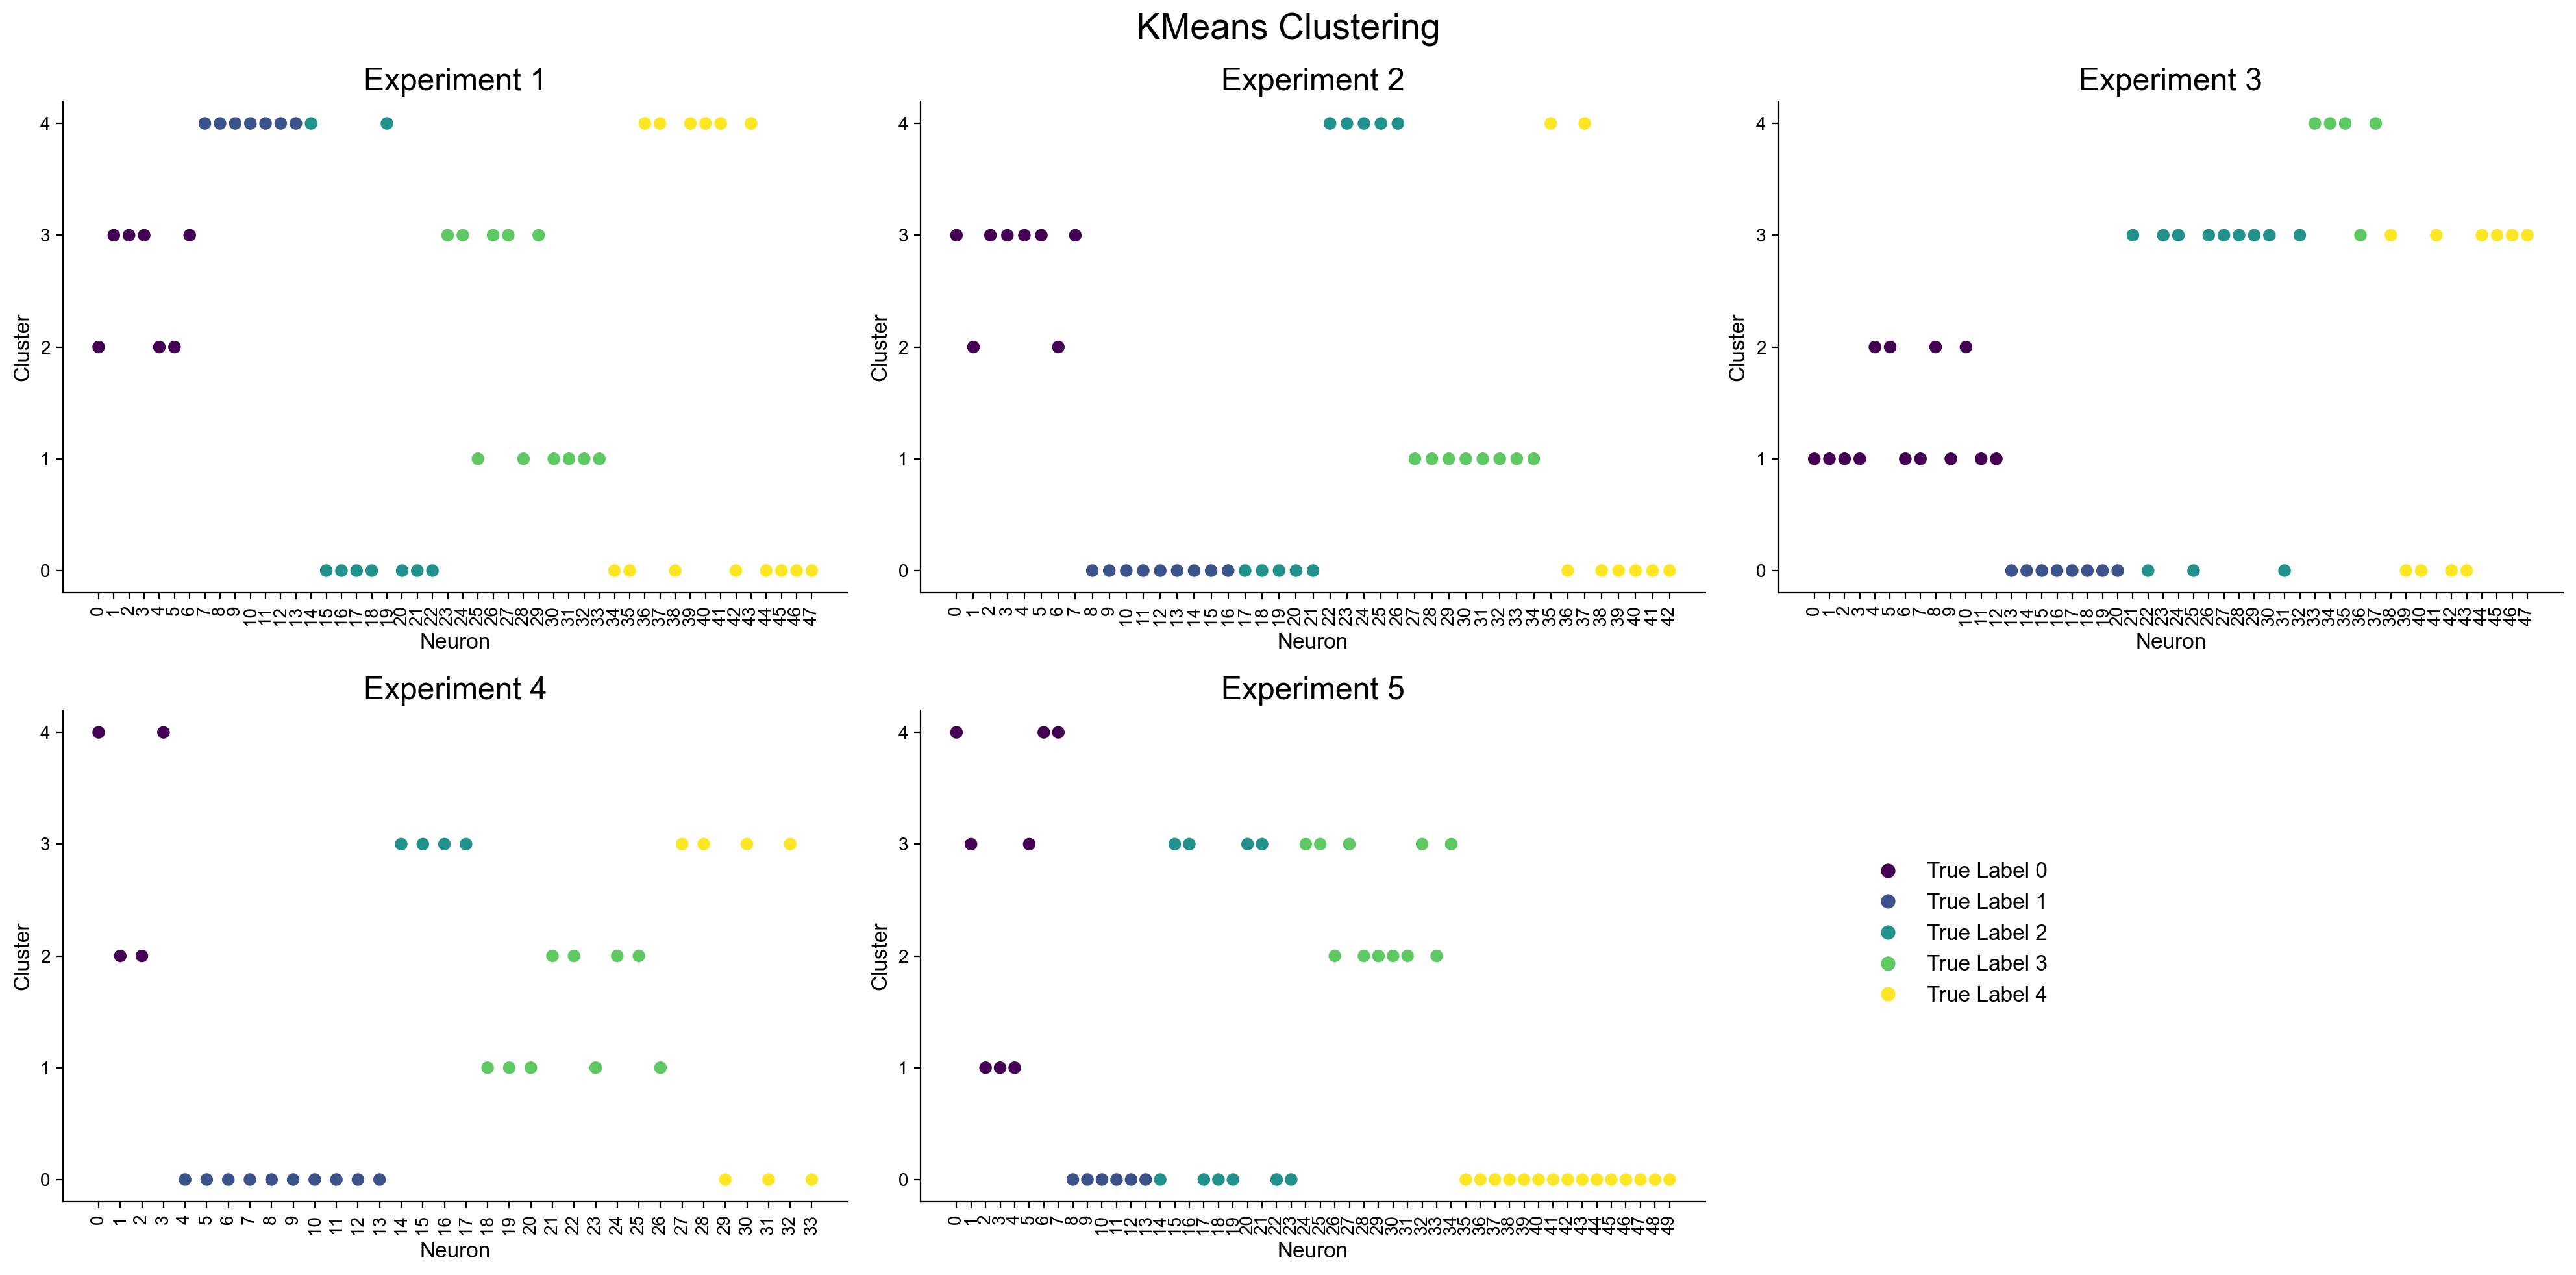

KMeans
NMI: mean=0.6370679541774886, std=0.049936246974566154
ARI: mean=0.41398334035820933, std=0.06725377854673592
ACC: mean=0.5949286365709074, std=0.04752434599877534


technique  nmi_mean   nmi_std  ari_mean   ari_std  acc_mean   acc_std
0    KMeans  0.637068  0.049936  0.413983  0.067254  0.594929  0.047524

In [64]:
# Load the data
datasets = os.listdir("new_data")

# Create a list to store the results
nmi_list = []
ari_list = []
acc_list = []


plt.figure(figsize=(20, 10))

# Loop through the datasets
for index, data in enumerate(datasets):
    data, num_clusts = torch.load(f"new_data/{data}")
    y_true = sum([[i] * j for i, j in enumerate(num_clusts)], start=[])
    
    neuron_num = np.arange(0, len(data))

    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=5, random_state=42, n_init=300)
    kmeans.fit_predict(data)

    # Evaluate the clusters
    nmi, ari, acc = eval_clusters(y_true, kmeans.labels_)
    nmi_list.append(nmi)
    ari_list.append(ari)
    acc_list.append(acc)

    # Plot the clusters
    plt.subplot(2, 3, index + 1)
    plt.scatter(neuron_num, kmeans.labels_, c=y_true, cmap='viridis')
    plt.xticks(np.arange(len(neuron_num)), rotation=90)
    plt.xlabel('Neuron')
    plt.ylabel('Cluster')
    plt.yticks(np.arange(5))
    plt.title(f'Experiment {index + 1}')

    # Generate legend for true labels
    unique_y_true = np.unique(y_true)
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_y_true)))
    true_label_legend = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], label=f'True Label {label}')
                         for i, label in enumerate(unique_y_true)]

# Figure settings
plt.suptitle('KMeans Clustering', fontsize=20)
plt.tight_layout()

# Adjust the legend position according to your layout
plt.figlegend(handles=true_label_legend, loc='lower right', bbox_to_anchor=(0.8, 0.2))

plt.savefig('figures/kmeans_only_scatter.png', dpi=300)
plt.savefig('figures/kmeans_only_scatter.pdf', format='pdf', dpi=2000)
plt.show()

print('KMeans')
print(f"NMI: mean={np.mean(nmi_list)}, std={np.std(nmi_list)}")
print(f"ARI: mean={np.mean(ari_list)}, std={np.std(ari_list)}")
print(f"ACC: mean={np.mean(acc_list)}, std={np.std(acc_list)}")

# Add the results to the dataframe
results.loc[0] = ['KMeans', np.mean(nmi_list), np.std(nmi_list), np.mean(ari_list), np.std(ari_list), np.mean(acc_list), np.std(acc_list)]
results

## PCA + KMEANS

### 2 Principal Components

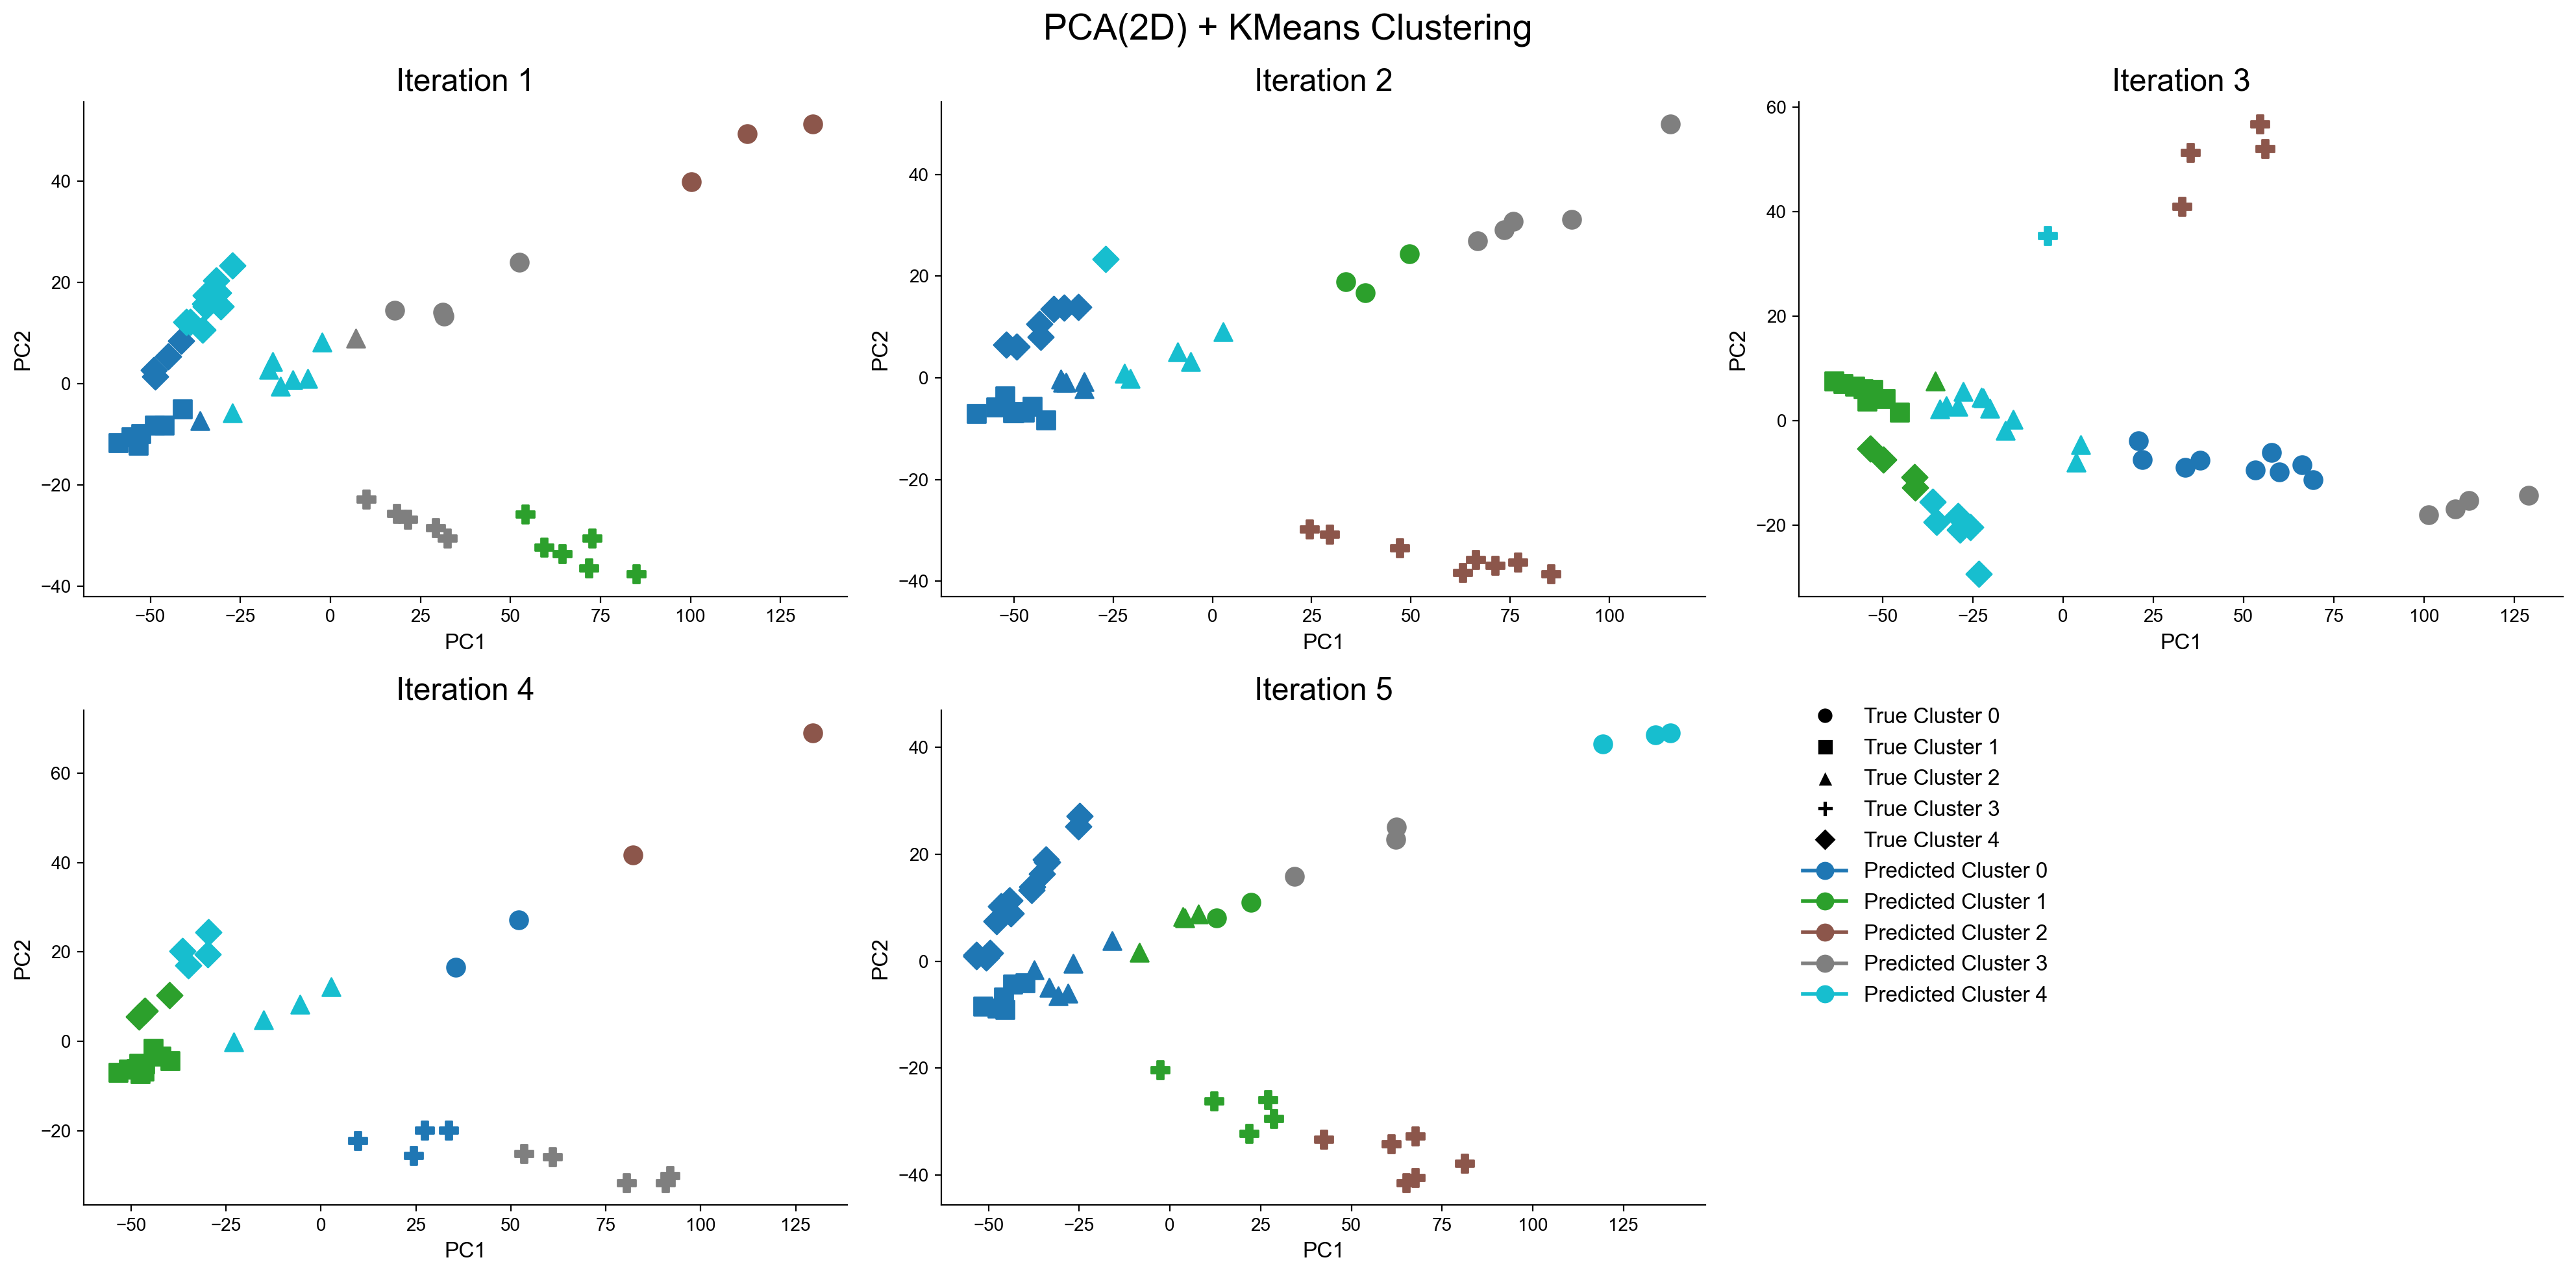

PCA(2D) + K-Means
NMI: mean=0.6463681105923399, std=0.053653043027975696
ARI: mean=0.4334457102317911, std=0.06763213113841947
ACC: mean=0.6069441404468765, std=0.04074262398971465


technique  nmi_mean   nmi_std  ari_mean   ari_std  acc_mean  \
0            KMeans  0.637068  0.049936  0.413983  0.067254  0.594929   
1  PCA(2D) + KMeans  0.646368  0.053653  0.433446  0.067632  0.606944   

    acc_std  
0  0.047524  
1  0.040743

In [65]:
# Load the data
datasets = os.listdir("new_data")

# Create a list to store the results
nmi_list = []
ari_list = []
acc_list = []

plt.figure(figsize=(20, 10))

# Loop through the datasets
for index, data in enumerate(datasets):
    data, num_clusts = torch.load(f"new_data/{data}")
    y_true = sum([[i] * j for i, j in enumerate(num_clusts)], start=[])

    neuron_num = np.arange(0, len(data))

    # Apply PCA to reduce the data to two dimensions for visualization  
    pca_2 = PCA(n_components=2)
    reduced_data_2 = pca_2.fit_transform(data)

    # Perform K-Means clustering
    pca_2_kmeans = KMeans(n_clusters=5, random_state=0, n_init=300)
    pca_2_kmeans.fit_predict(reduced_data_2)

    # Evaluate the clusters
    nmi, ari, acc = eval_clusters(y_true, pca_2_kmeans.labels_)
    nmi_list.append(nmi)
    ari_list.append(ari)
    acc_list.append(acc)

    plt.subplot(2, 3, index + 1)

    markers = ['o', 's', '^', 'P', 'D', '*'] 
    colors = plt.cm.get_cmap("tab10", len(np.unique(y_true)))

    true_cluster_legend = [Line2D([0], [0], marker=markers[i], color='w', 
                             markerfacecolor='black', label=f'True Cluster {i}')
                      for i in range(len(np.unique(y_true)))]

    predicted_cluster_legend = [Line2D([0], [0], marker='o', color=colors(i),
                                   label=f'Predicted Cluster {i}')
                           for i in range(5)] 
    
    legend_elements = true_cluster_legend + predicted_cluster_legend

    # Plot each data point
    for i in range(len(reduced_data_2)):
        plt.scatter(reduced_data_2[i, 0], reduced_data_2[i, 1],  
                    color=colors(pca_2_kmeans.labels_[i]),
                    marker=markers[y_true[i]],
                    s=100,
                    alpha=1)
        
        plt.ylabel('PC2')
        plt.xlabel('PC1')
        plt.title(f'Iteration {index + 1}')

# Figure settings
plt.suptitle('PCA(2D) + KMeans Clustering', fontsize=20)
plt.tight_layout()
plt.figlegend(handles=legend_elements, loc='lower right', bbox_to_anchor=(0.8, 0.2))
plt.savefig('figures/pca_kmeans_scatter.png', dpi = 300)
plt.savefig('figures/pca_kmeans_scatter.pdf', format='pdf', dpi=2000)
plt.show()

print("PCA(2D) + K-Means")
print(f"NMI: mean={np.mean(nmi_list)}, std={np.std(nmi_list)}")
print(f"ARI: mean={np.mean(ari_list)}, std={np.std(ari_list)}")
print(f"ACC: mean={np.mean(acc_list)}, std={np.std(acc_list)}")

# Add the results to the dataframe
results.loc[1] = ['PCA(2D) + KMeans', np.mean(nmi_list), np.std(nmi_list), np.mean(ari_list), np.std(ari_list), np.mean(acc_list), np.std(acc_list)]
results

### 5 Principal Components

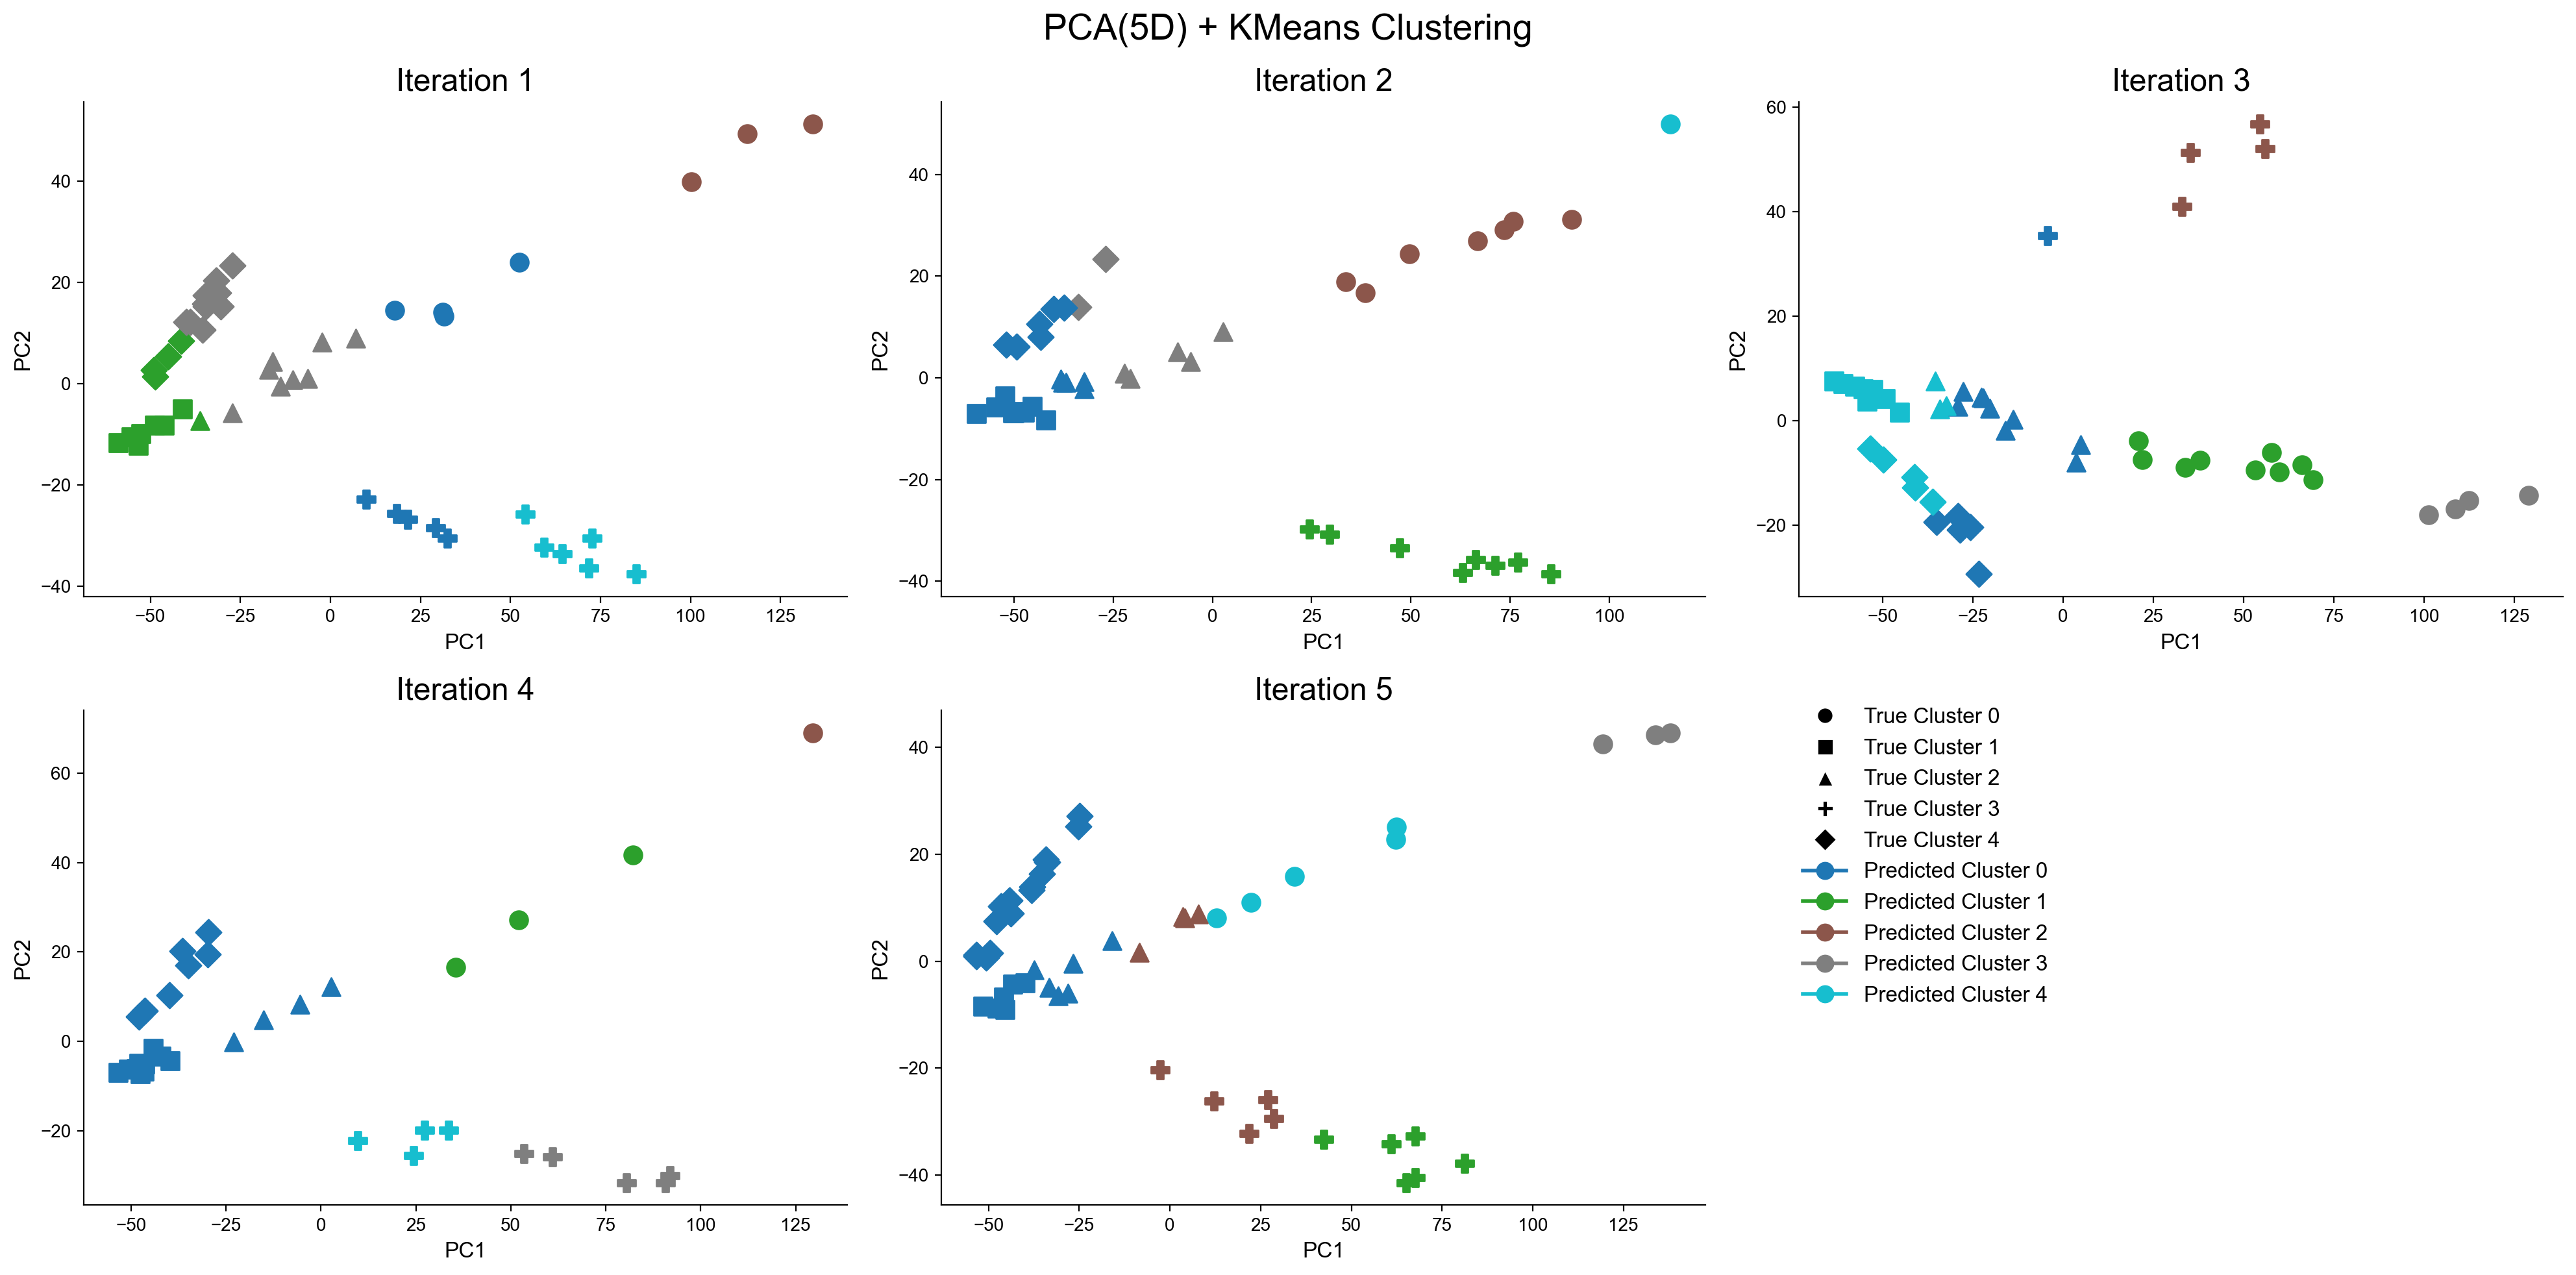

PCA(5D) + K-Means
NMI: mean=0.6508027362411395, std=0.022446771056717964
ARI: mean=0.4012305921701308, std=0.0299770217471855
ACC: mean=0.598266073871409, std=0.050074035549507546


technique  nmi_mean   nmi_std  ari_mean   ari_std  acc_mean  \
0            KMeans  0.637068  0.049936  0.413983  0.067254  0.594929   
1  PCA(2D) + KMeans  0.646368  0.053653  0.433446  0.067632  0.606944   
2  PCA(5D) + KMeans  0.650803  0.022447  0.401231  0.029977  0.598266   

    acc_std  
0  0.047524  
1  0.040743  
2  0.050074

In [66]:
# Load the data
datasets = os.listdir("new_data")

# Create a list to store the results
nmi_list = []
ari_list = []
acc_list = []

plt.figure(figsize=(20, 10))

# Loop through the datasets
for index, data in enumerate(datasets):
    data, num_clusts = torch.load(f"new_data/{data}")
    y_true = sum([[i] * j for i, j in enumerate(num_clusts)], start=[])

    neuron_num = np.arange(0, len(data))

    # Apply PCA to reduce the data to 5 dimensions for visualization  
    pca_5 = PCA(n_components=5)
    reduced_data_5 = pca_5.fit_transform(data)

    # Perform K-Means clustering
    pca_5_kmeans = KMeans(n_clusters=5, random_state=0, n_init=300)
    pca_5_kmeans.fit_predict(reduced_data_5)

    # Evaluate the clusters
    nmi, ari, acc = eval_clusters(y_true, pca_5_kmeans.labels_)
    nmi_list.append(nmi)
    ari_list.append(ari)
    acc_list.append(acc)

    plt.subplot(2, 3, index + 1)

    markers = ['o', 's', '^', 'P', 'D', '*']

    colors = plt.cm.get_cmap("tab10", len(np.unique(y_true)))

    true_cluster_legend = [Line2D([0], [0], marker=markers[i], color='w',
                                markerfacecolor='black', label=f'True Cluster {i}')
                        for i in range(len(np.unique(y_true)))]
    predicted_cluster_legend = [Line2D([0], [0], marker='o', color=colors(i),
                                    label=f'Predicted Cluster {i}')
                            for i in range(5)]
    legend_elements = true_cluster_legend + predicted_cluster_legend

    # Plot each data point
    for i in range(len(reduced_data_5)):
        plt.scatter(reduced_data_5[i, 0], reduced_data_5[i, 1],
                    color=colors(pca_5_kmeans.labels_[i]),
                    marker=markers[y_true[i]],
                    s=100,
                    alpha=1)
        plt.ylabel('PC2')
        plt.xlabel('PC1')
        plt.title(f'Iteration {index + 1}')

# Figure settings
plt.suptitle('PCA(5D) + KMeans Clustering', fontsize=20)
plt.tight_layout()
plt.figlegend(handles=legend_elements, loc='lower right', bbox_to_anchor=(0.8, 0.2))
plt.savefig('figures/pca5_kmeans_scatter.png', dpi = 300)
plt.savefig('figures/pca5_kmeans_scatter.pdf', format='pdf', dpi=2000)
plt.show()

print("PCA(5D) + K-Means")
print(f"NMI: mean={np.mean(nmi_list)}, std={np.std(nmi_list)}")
print(f"ARI: mean={np.mean(ari_list)}, std={np.std(ari_list)}")
print(f"ACC: mean={np.mean(acc_list)}, std={np.std(acc_list)}")

# Add the results to the dataframe
results.loc[2] = ['PCA(5D) + KMeans', np.mean(nmi_list), np.std(nmi_list), np.mean(ari_list), np.std(ari_list), np.mean(acc_list), np.std(acc_list)]
results

### 10 Principal Components

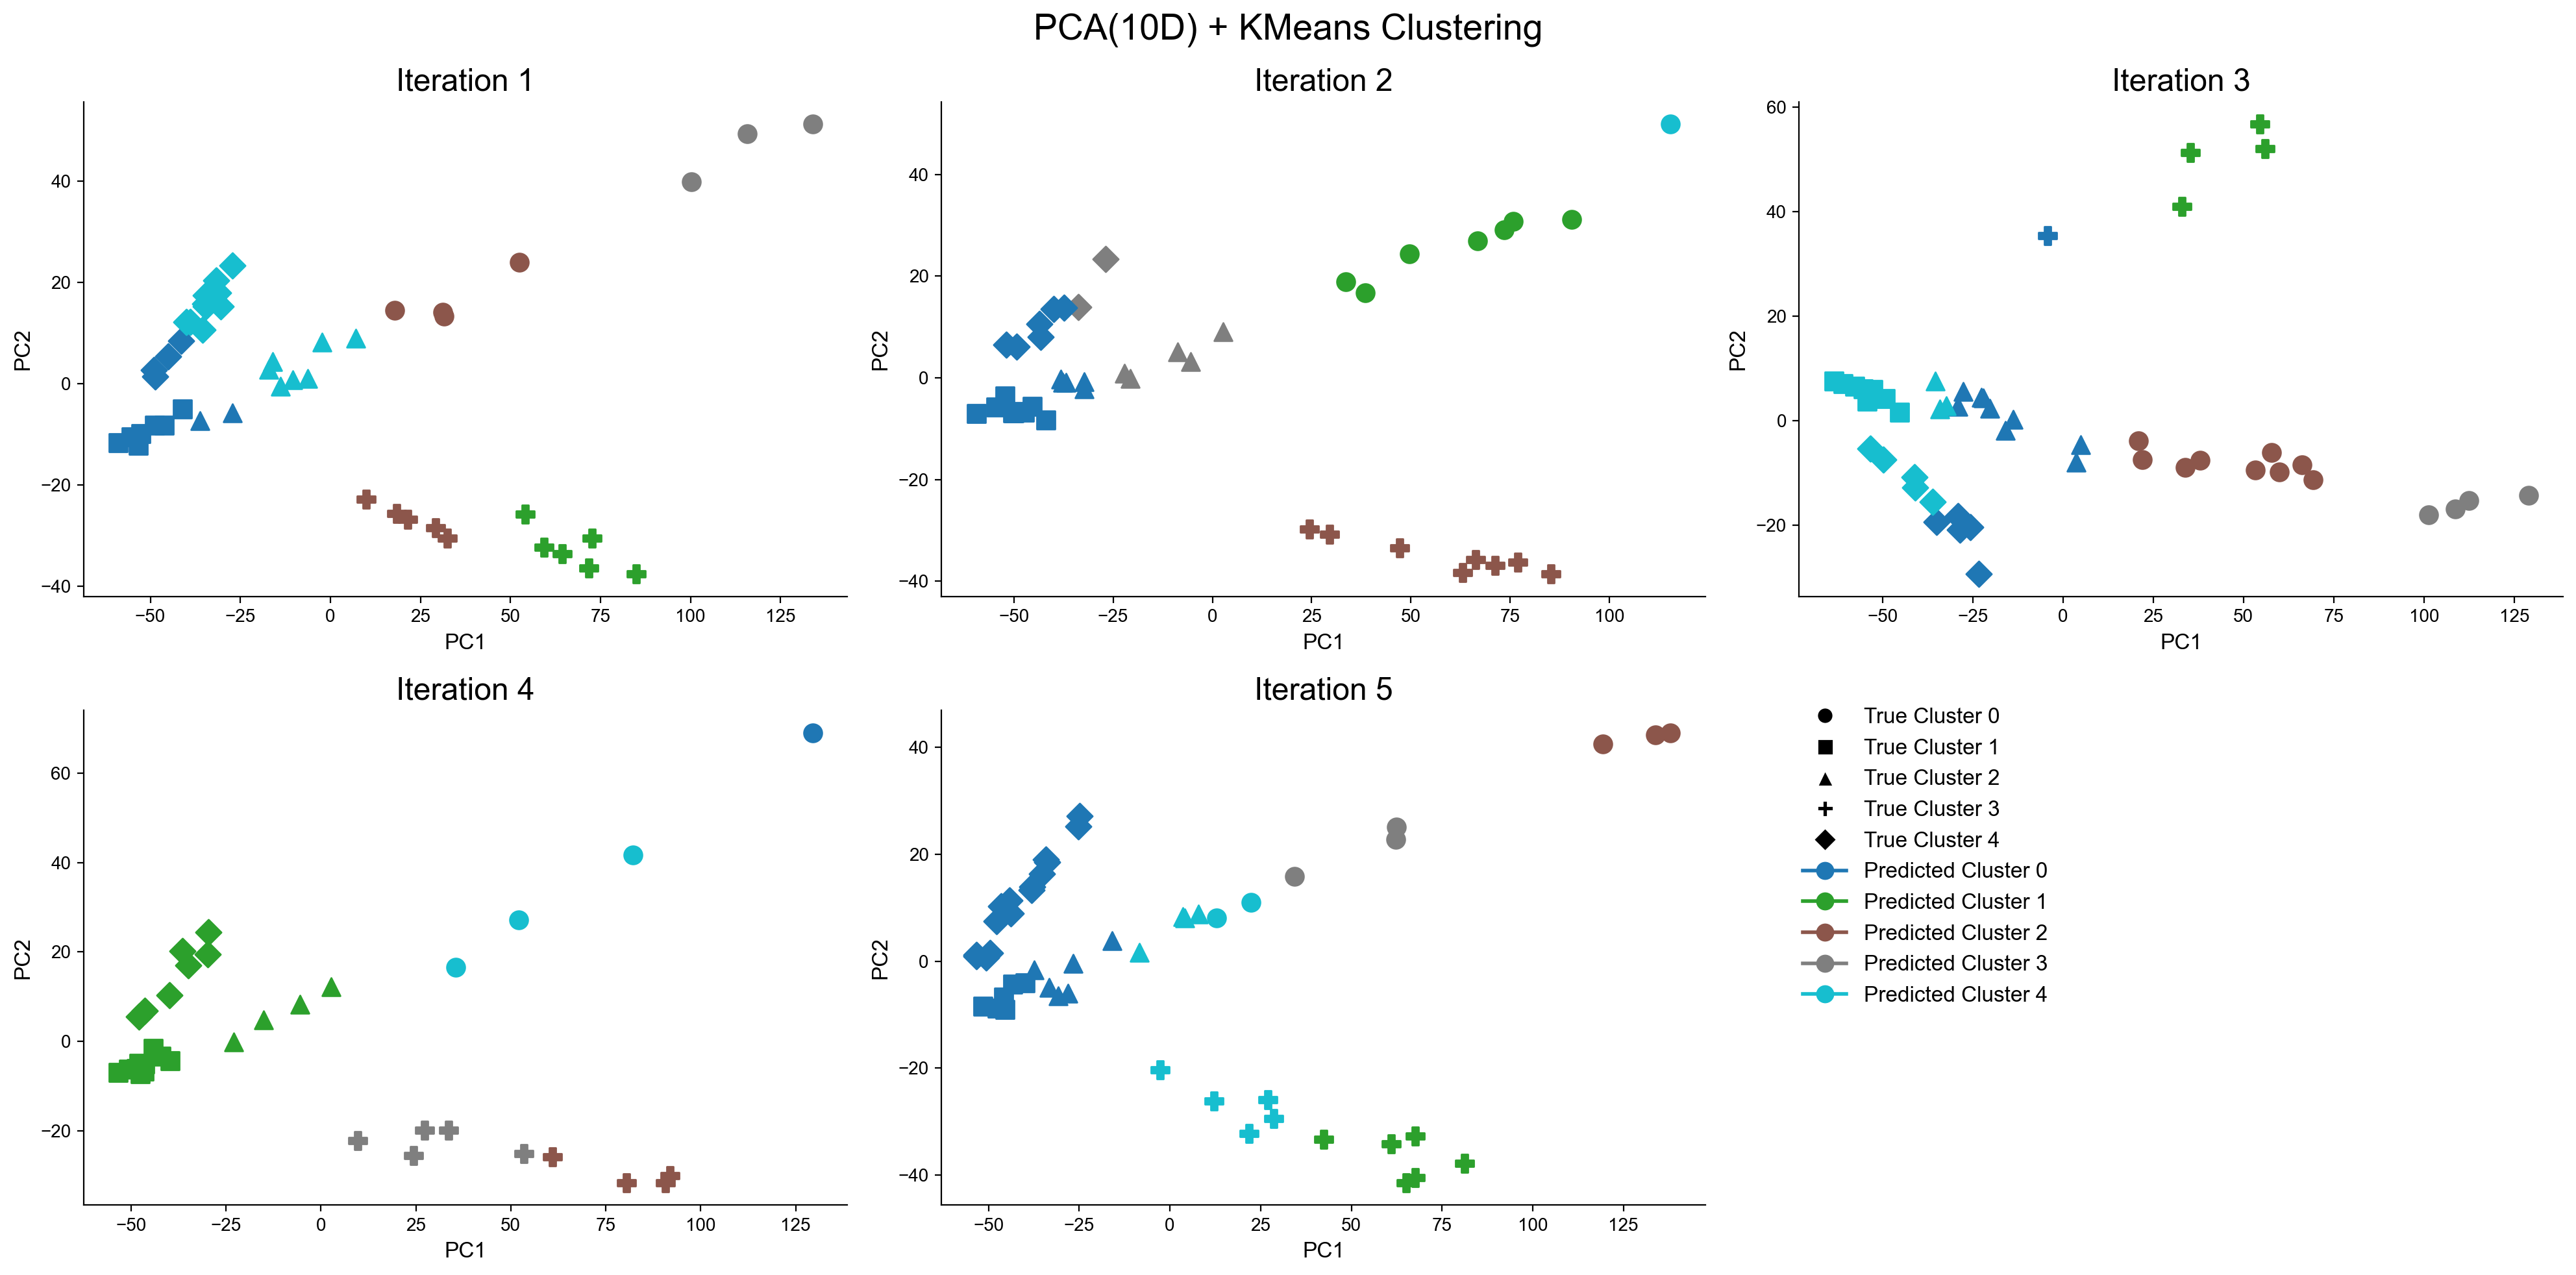

PCA(10D) + K-Means
NMI: mean=0.6338411569340852, std=0.042087237897244376
ARI: mean=0.38887116751118656, std=0.03661300745733692
ACC: mean=0.590266073871409, std=0.05230359660822465


technique  nmi_mean   nmi_std  ari_mean   ari_std  acc_mean  \
0             KMeans  0.637068  0.049936  0.413983  0.067254  0.594929   
1   PCA(2D) + KMeans  0.646368  0.053653  0.433446  0.067632  0.606944   
2   PCA(5D) + KMeans  0.650803  0.022447  0.401231  0.029977  0.598266   
3  PCA(10D) + KMeans  0.633841  0.042087  0.388871  0.036613  0.590266   

    acc_std  
0  0.047524  
1  0.040743  
2  0.050074  
3  0.052304

In [67]:
# Load the data
datasets = os.listdir("new_data")

# Create a list to store the results
nmi_list = []
ari_list = []
acc_list = []

plt.figure(figsize=(20, 10))

# Loop through the datasets
for index,  data in enumerate(datasets):
    data, num_clusts = torch.load(f"new_data/{data}")
    y_true = sum([[i] * j for i, j in enumerate(num_clusts)], start=[])

    neuron_num = np.arange(0, len(data))

    # Apply PCA to reduce the data to two dimensions for visualization  
    pca_10 = PCA(n_components=10)
    reduced_data_10 = pca_10.fit_transform(data)

    # Perform K-Means clustering
    pca_10_kmeans = KMeans(n_clusters=5, random_state=0, n_init=300)
    pca_10_kmeans.fit_predict(reduced_data_10)

    # Evaluate the clusters
    nmi, ari, acc = eval_clusters(y_true, pca_10_kmeans.labels_)
    nmi_list.append(nmi)
    ari_list.append(ari)
    acc_list.append(acc)

    plt.subplot(2, 3, index + 1)

    markers = ['o', 's', '^', 'P', 'D', '*']

    colors = plt.cm.get_cmap("tab10", len(np.unique(y_true)))

    true_cluster_legend = [Line2D([0], [0], marker=markers[i], color='w',
                                markerfacecolor='black', label=f'True Cluster {i}')
                        for i in range(len(np.unique(y_true)))]
    predicted_cluster_legend = [Line2D([0], [0], marker='o', color=colors(i),
                                    label=f'Predicted Cluster {i}')
                            for i in range(5)]
    legend_elements = true_cluster_legend + predicted_cluster_legend

    # Plot each data point
    for i in range(len(reduced_data_10)):
        plt.scatter(reduced_data_10[i, 0], reduced_data_10[i, 1],
                    color=colors(pca_10_kmeans.labels_[i]),
                    marker=markers[y_true[i]],
                    s=100,
                    alpha=1)
        plt.ylabel('PC2')
        plt.xlabel('PC1')
        plt.title(f'Iteration {index + 1}')

# Figure settings
plt.suptitle('PCA(10D) + KMeans Clustering', fontsize=20)
plt.tight_layout()  
plt.figlegend(handles=legend_elements, loc='lower right', bbox_to_anchor=(0.8, 0.2))
plt.savefig('figures/pca10_kmeans_scatter.png', dpi = 300)
plt.savefig('figures/pca10_kmeans_scatter.pdf', format='pdf', dpi=2000)
plt.show()

print("PCA(10D) + K-Means")
print(f"NMI: mean={np.mean(nmi_list)}, std={np.std(nmi_list)}")
print(f"ARI: mean={np.mean(ari_list)}, std={np.std(ari_list)}")
print(f"ACC: mean={np.mean(acc_list)}, std={np.std(acc_list)}")

# Add the results to the dataframe
results.loc[3] = ['PCA(10D) + KMeans', np.mean(nmi_list), np.std(nmi_list), np.mean(ari_list), np.std(ari_list), np.mean(acc_list), np.std(acc_list)]
results

## TSNE + KMEANS

### 2 Principal Components

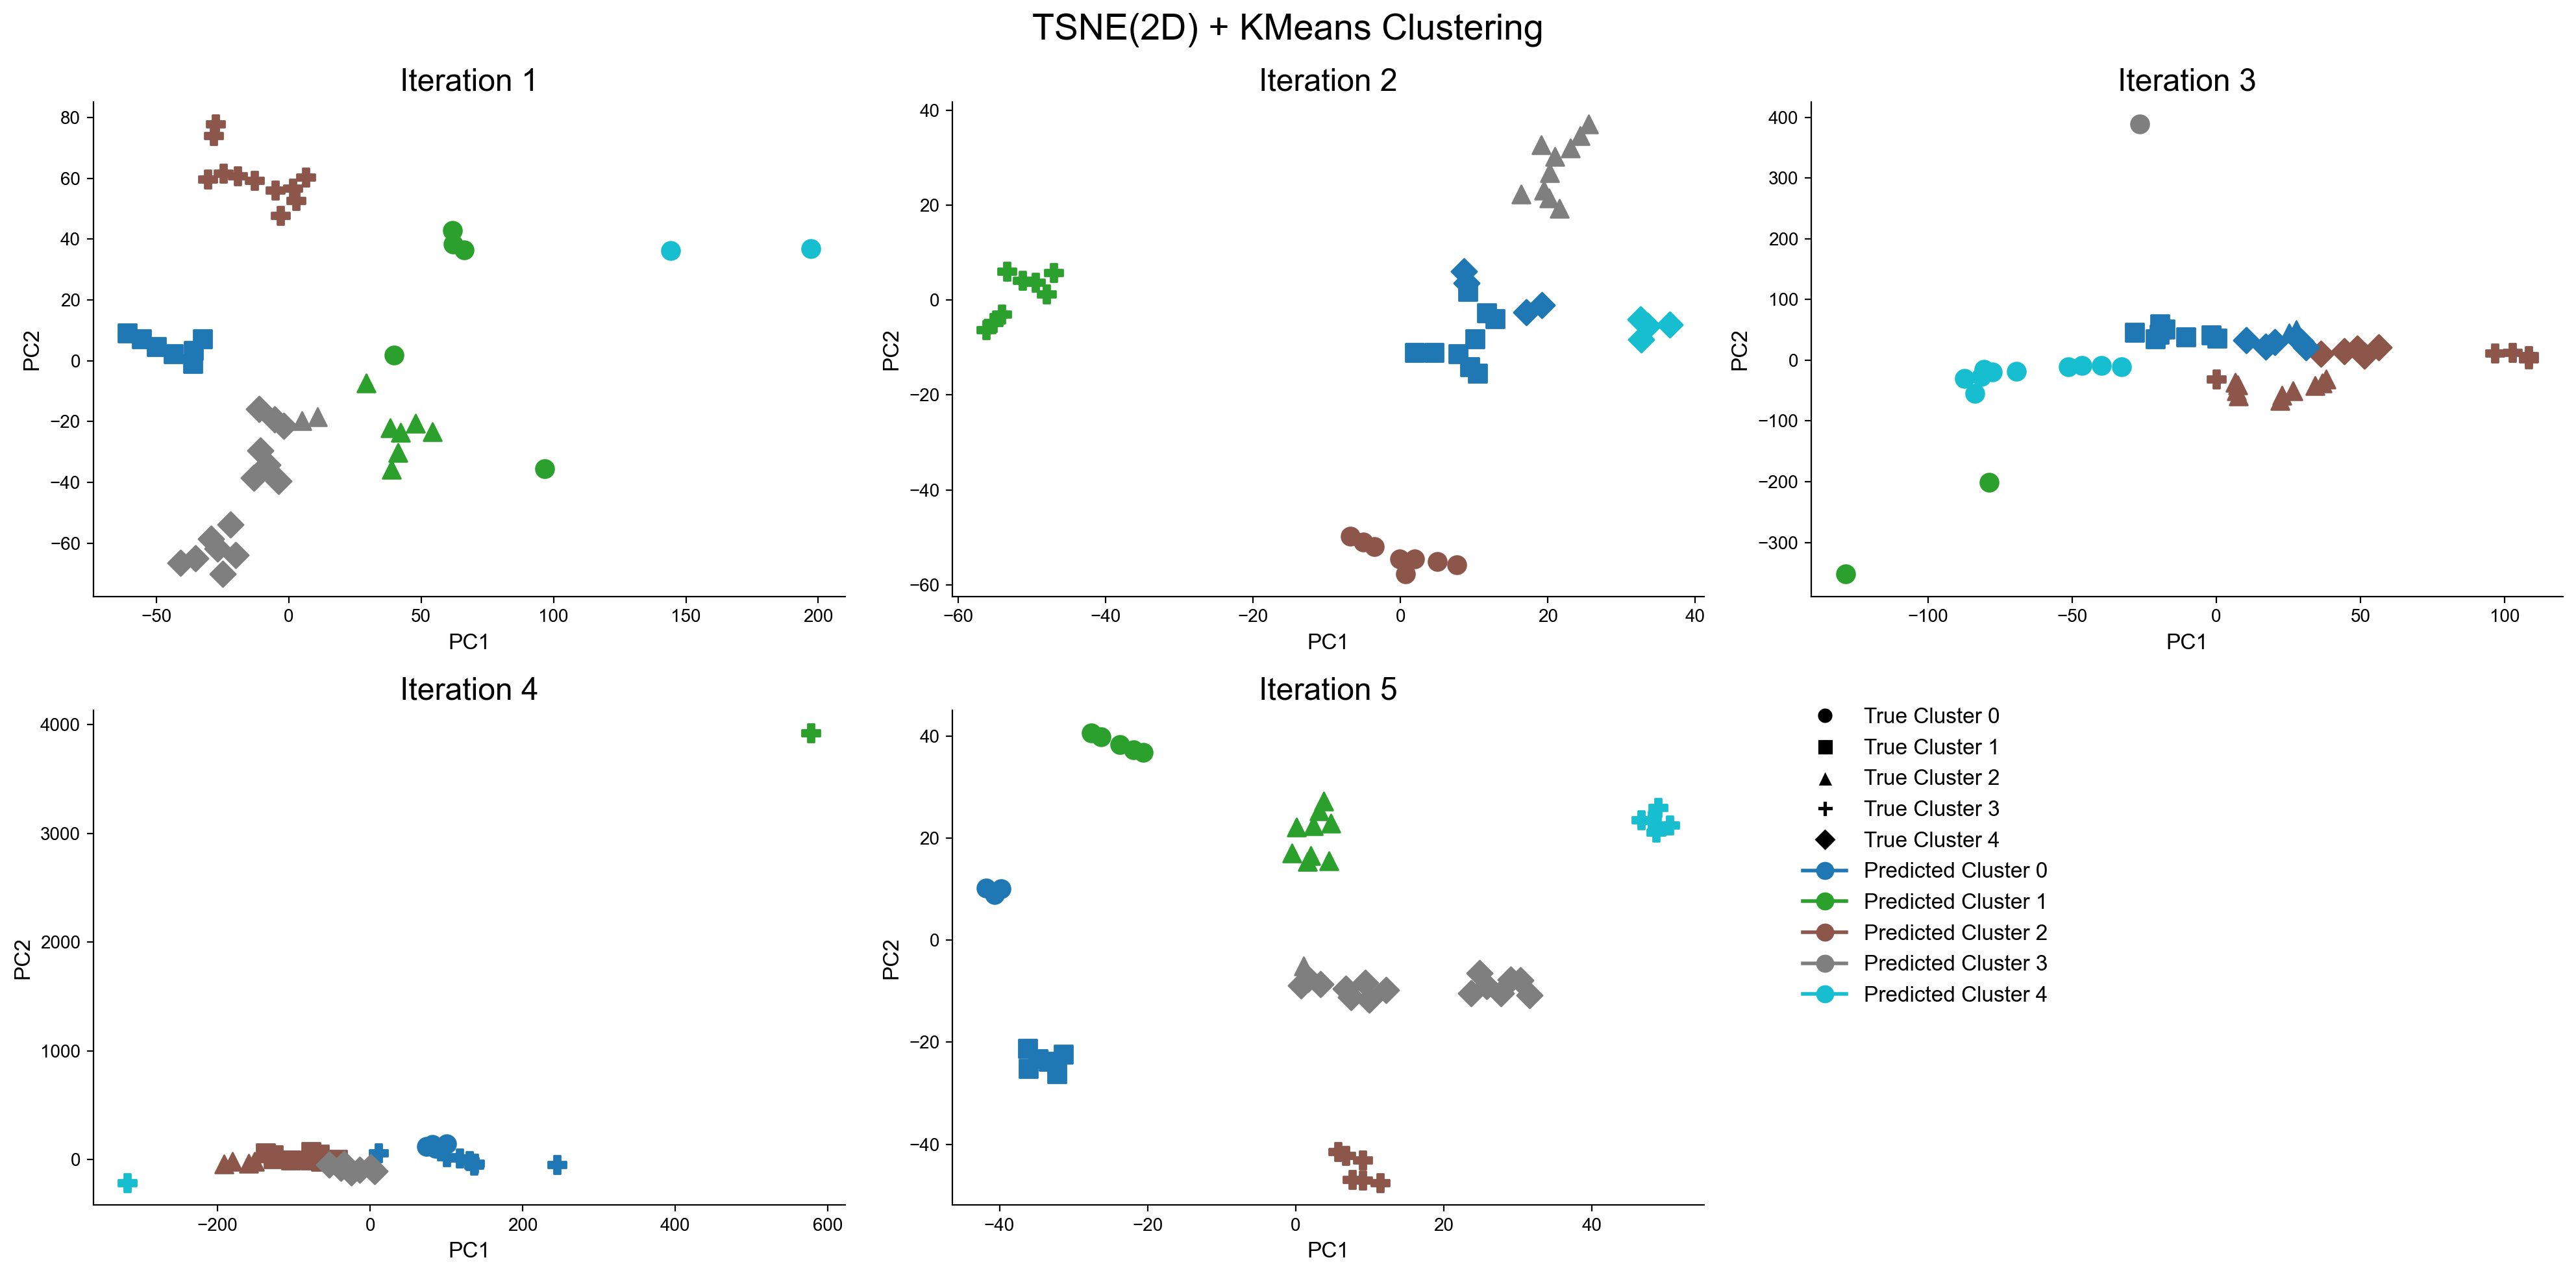

TSNE(2D) + K-Means
NMI: mean=0.7741410451901904, std=0.10659151775241581
ARI: mean=0.6509555871536442, std=0.1542334602183882
ACC: mean=0.7540718194254445, std=0.1149205278897669


technique  nmi_mean   nmi_std  ari_mean   ari_std  acc_mean  \
0             KMeans  0.637068  0.049936  0.413983  0.067254  0.594929   
1   PCA(2D) + KMeans  0.646368  0.053653  0.433446  0.067632  0.606944   
2   PCA(5D) + KMeans  0.650803  0.022447  0.401231  0.029977  0.598266   
3  PCA(10D) + KMeans  0.633841  0.042087  0.388871  0.036613  0.590266   
4  TSNE(2D) + KMeans  0.774141  0.106592  0.650956  0.154233  0.754072   

    acc_std  
0  0.047524  
1  0.040743  
2  0.050074  
3  0.052304  
4  0.114921

In [68]:
# Load the data
datasets = os.listdir("new_data")

# Create a list to store the results
nmi_list = []
ari_list = []
acc_list = []

plt.figure(figsize=(20, 10))

# Loop through the datasets
for index, data in enumerate(datasets):
    data, num_clusts = torch.load(f"new_data/{data}")
    y_true = sum([[i] * j for i, j in enumerate(num_clusts)], start=[])

    neuron_num = np.arange(0, len(data))

    # Initialize a TSNE instance
    tsne_2 = TSNE(n_components=2, random_state=42, perplexity=2, learning_rate=40)
    reduced_data_tsne_2 = tsne_2.fit_transform(data)

    # Specify the number of clusters for K-Means
    tsne_2_kmeans = KMeans(n_clusters=5, random_state=42, n_init=300)

    # Apply K-Means to the t-SNE reduced data
    tsne_2_kmeans.fit(reduced_data_tsne_2)

    # Evaluate the clusters
    nmi, ari, acc = eval_clusters(y_true, tsne_2_kmeans.labels_)
    nmi_list.append(nmi)
    ari_list.append(ari)
    acc_list.append(acc)

    plt.subplot(2, 3, index + 1)

    markers = ['o', 's', '^', 'P', 'D', '*']

    colors = plt.cm.get_cmap("tab10", len(np.unique(y_true)))

    true_cluster_legend = [Line2D([0], [0], marker=markers[i], color='w',
                                markerfacecolor='black', label=f'True Cluster {i}')
                        for i in range(len(np.unique(y_true)))]
    predicted_cluster_legend = [Line2D([0], [0], marker='o', color=colors(i),
                                    label=f'Predicted Cluster {i}')
                            for i in range(5)]
    legend_elements = true_cluster_legend + predicted_cluster_legend

    # Plot each data point
    for i in range(len(reduced_data_tsne_2)):
        plt.scatter(reduced_data_tsne_2[i, 0], reduced_data_tsne_2[i, 1],
                    color=colors(tsne_2_kmeans.labels_[i]),
                    marker=markers[y_true[i]],
                    s=100,
                    alpha=1)
        plt.ylabel('PC2')
        plt.xlabel('PC1')
        plt.title(f'Iteration {index + 1}')

# Figure settings
plt.suptitle('TSNE(2D) + KMeans Clustering', fontsize=20)
plt.tight_layout()
plt.figlegend(handles=legend_elements, loc='lower right', bbox_to_anchor=(0.8, 0.2))
plt.savefig('figures/tsne2_kmeans_scatter.png', dpi = 300)
plt.savefig('figures/tsne2_kmeans_scatter.pdf', format='pdf', dpi=2000)
plt.show()

print("TSNE(2D) + K-Means")
print(f"NMI: mean={np.mean(nmi_list)}, std={np.std(nmi_list)}")
print(f"ARI: mean={np.mean(ari_list)}, std={np.std(ari_list)}")
print(f"ACC: mean={np.mean(acc_list)}, std={np.std(acc_list)}")

# Add the results to the dataframe
results.loc[4] = ['TSNE(2D) + KMeans', np.mean(nmi_list), np.std(nmi_list), np.mean(ari_list), np.std(ari_list), np.mean(acc_list), np.std(acc_list)]
results

### 3 Principal Components

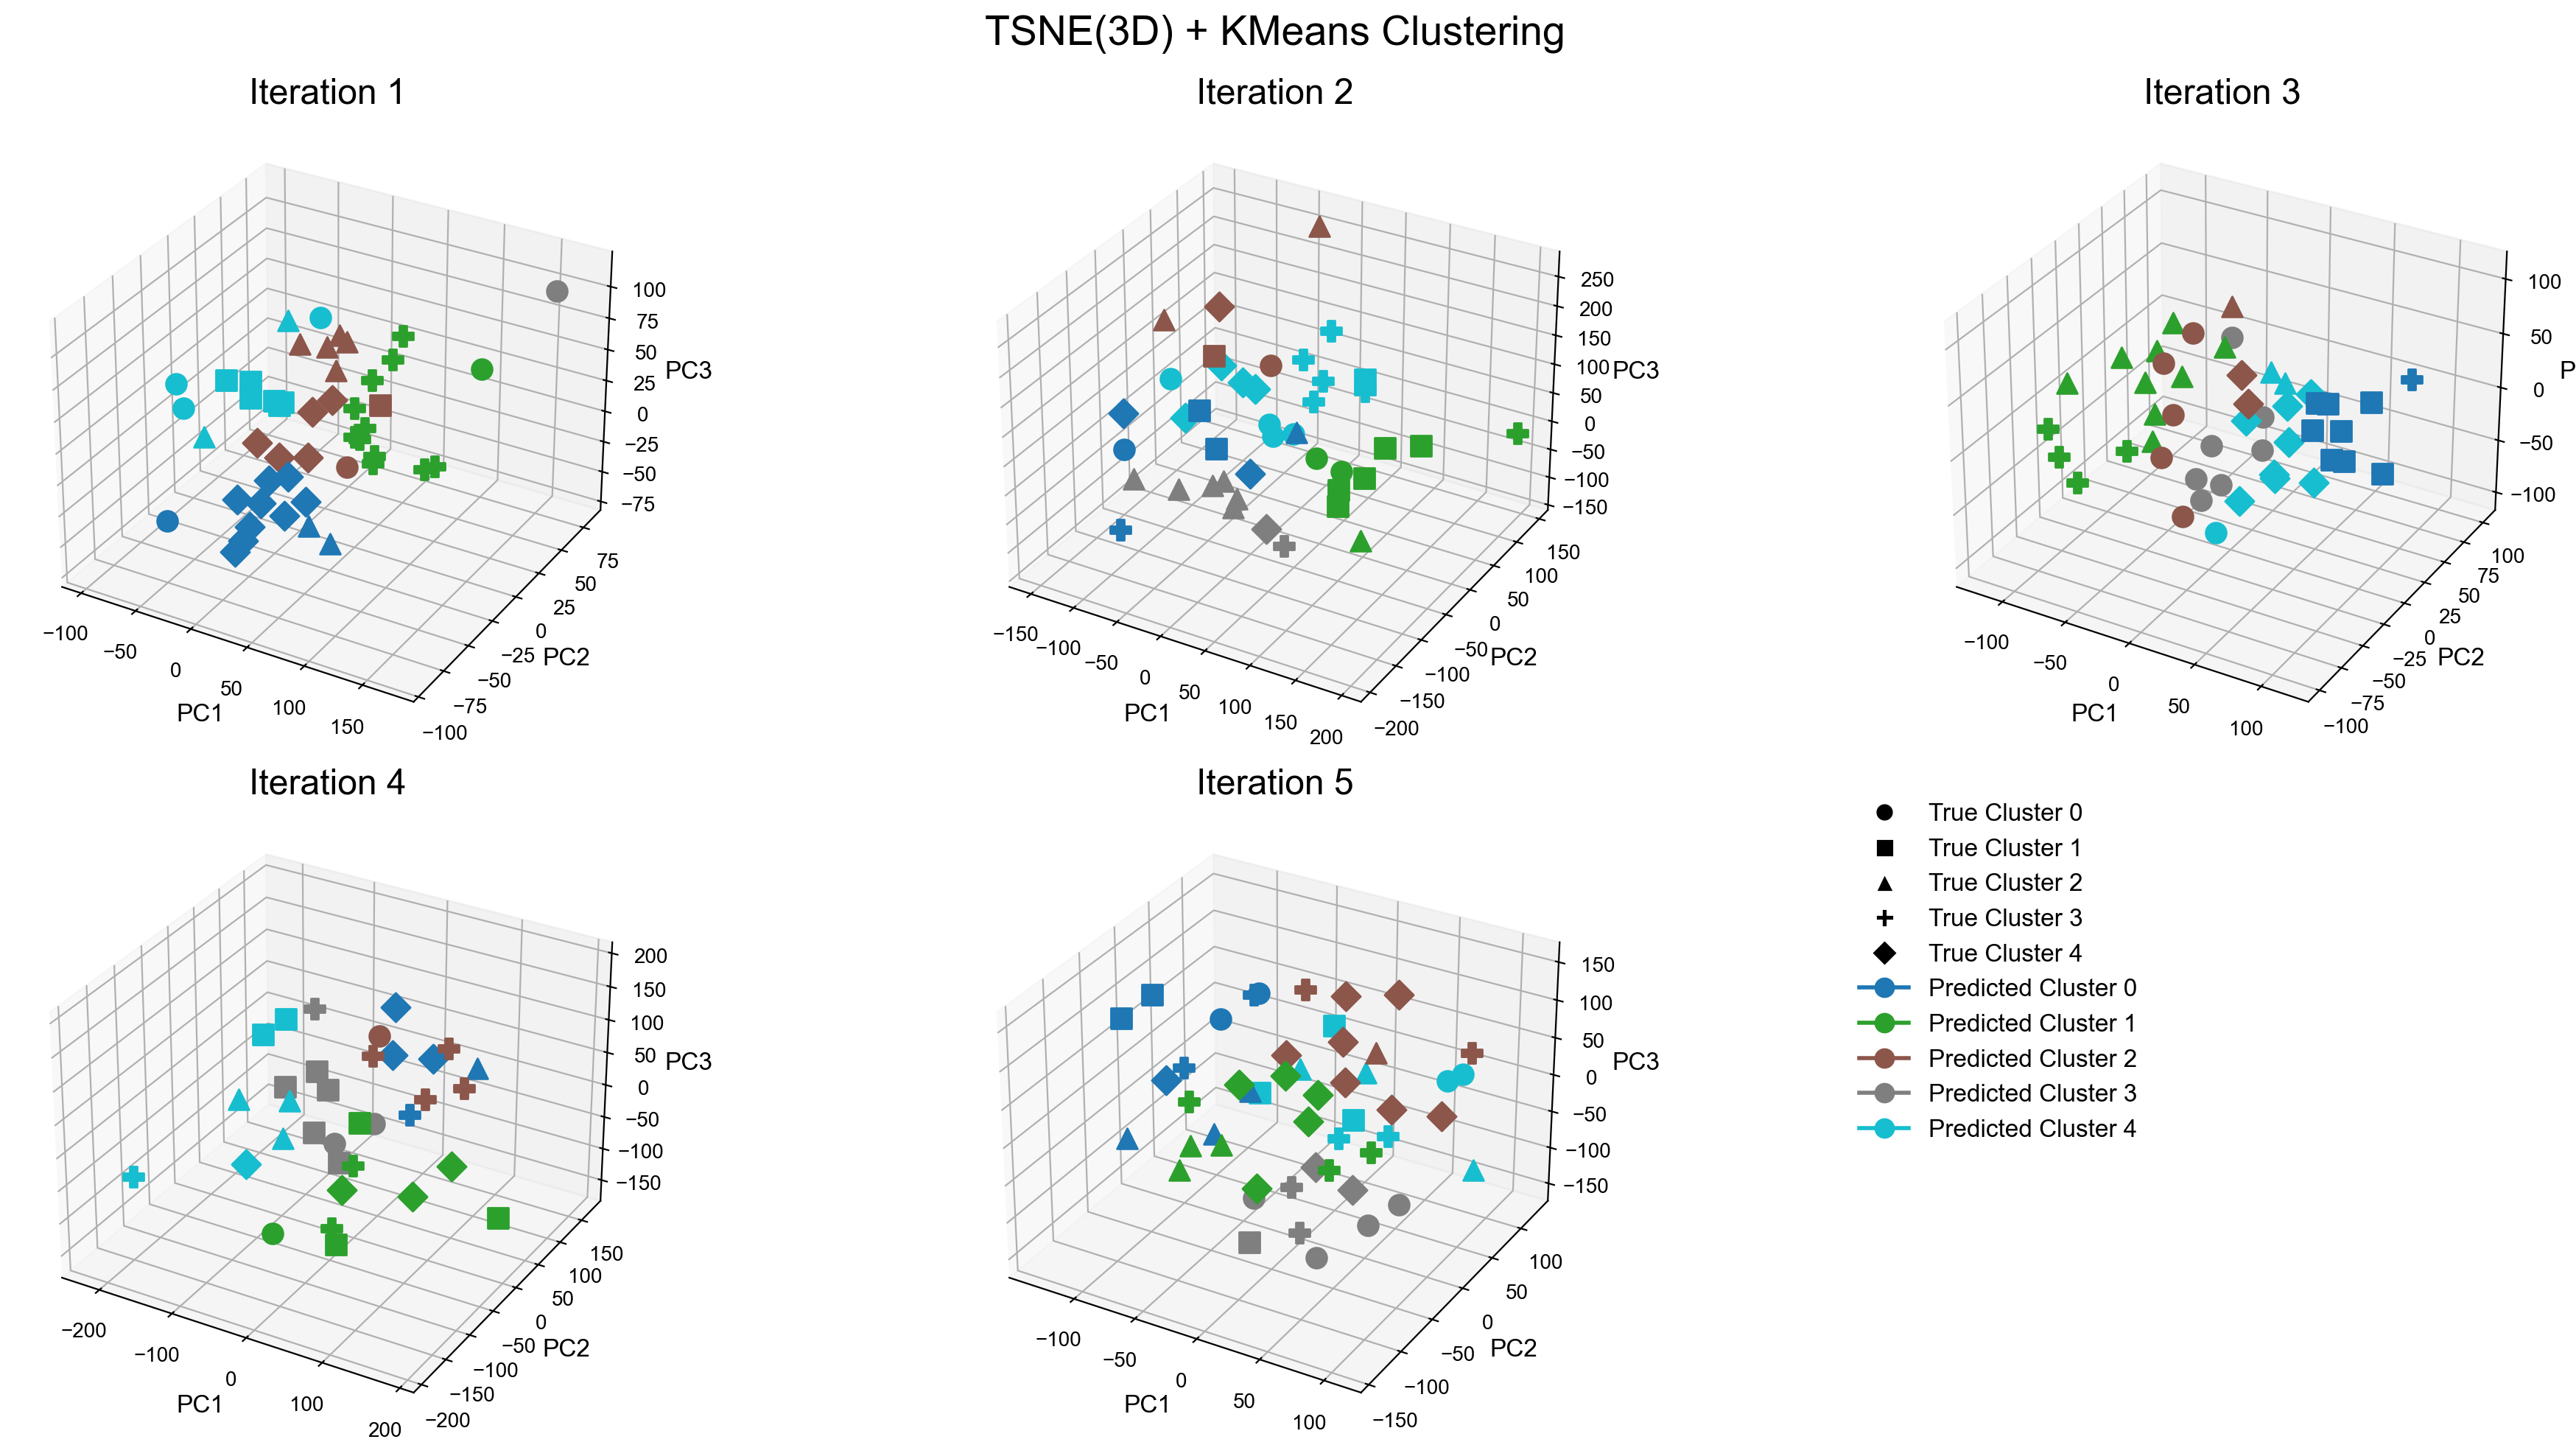

TSNE(3D) + K-Means
NMI: mean=0.3952398865151498, std=0.1621499309227429
ARI: mean=0.244213189926559, std=0.1764957673145144
ACC: mean=0.529156406748746, std=0.11449919886416106


technique  nmi_mean   nmi_std  ari_mean   ari_std  acc_mean  \
0             KMeans  0.637068  0.049936  0.413983  0.067254  0.594929   
1   PCA(2D) + KMeans  0.646368  0.053653  0.433446  0.067632  0.606944   
2   PCA(5D) + KMeans  0.650803  0.022447  0.401231  0.029977  0.598266   
3  PCA(10D) + KMeans  0.633841  0.042087  0.388871  0.036613  0.590266   
4  TSNE(2D) + KMeans  0.774141  0.106592  0.650956  0.154233  0.754072   
5  TSNE(3D) + KMeans  0.395240  0.162150  0.244213  0.176496  0.529156   

    acc_std  
0  0.047524  
1  0.040743  
2  0.050074  
3  0.052304  
4  0.114921  
5  0.114499

In [69]:
# Load the data
datasets = os.listdir("new_data")

nmi_list = []
ari_list = []
acc_list = []

plt.figure(figsize=(20, 10))

# Loop through the datasets
for index, data in enumerate(datasets):
    data, num_clusts = torch.load(f"new_data/{data}")
    y_true = sum([[i] * j for i, j in enumerate(num_clusts)], start=[])

    neuron_num = np.arange(0, len(data))

    # Initialize a TSNE instance
    tsne_3 = TSNE(n_components=3, random_state=42, perplexity=2, learning_rate=40)
    reduced_data_tsne_3 = tsne_3.fit_transform(data)

    # Specify the number of clusters for K-Means
    tsne_3_kmeans = KMeans(n_clusters=5, random_state=42, n_init=300)

    # Apply K-Means to the t-SNE reduced data
    tsne_3_kmeans.fit(reduced_data_tsne_3)

    # Evaluate the clusters
    nmi, ari, acc = eval_clusters(y_true, tsne_3_kmeans.labels_)
    nmi_list.append(nmi)
    ari_list.append(ari)
    acc_list.append(acc)

    ax = plt.subplot(2, 3, index + 1, projection='3d')

    markers = ['o', 's', '^', 'P', 'D', '*']

    colors = plt.cm.get_cmap("tab10", len(np.unique(y_true)))

    true_cluster_legend = [Line2D([0], [0], marker=markers[i], color='w',
                                markerfacecolor='black', label=f'True Cluster {i}')
                        for i in range(len(np.unique(y_true)))]
    predicted_cluster_legend = [Line2D([0], [0], marker='o', color=colors(i),
                                    label=f'Predicted Cluster {i}')
                            for i in range(5)]
    legend_elements = true_cluster_legend + predicted_cluster_legend

    # Plot each data point
    for i in range(len(reduced_data_tsne_3)):
        ax.scatter(reduced_data_tsne_3[i, 0], reduced_data_tsne_3[i, 1], reduced_data_tsne_3[i, 2],
                    color=colors(tsne_3_kmeans.labels_[i]),
                    marker=markers[y_true[i]],
                    s=100,
                    alpha=1)
        
        ax.set_zlabel('PC3')
        ax.set_ylabel('PC2')
        ax.set_xlabel('PC1')
        plt.title(f'Iteration {index + 1}')    

# Figure settings
plt.suptitle('TSNE(3D) + KMeans Clustering', fontsize=20)
plt.tight_layout()
plt.figlegend(handles=legend_elements, loc='lower right', bbox_to_anchor=(0.8, 0.2))
plt.savefig('figures/tsne3_kmeans_scatter.png', dpi = 300)
plt.savefig('figures/tsne3_kmeans_scatter.pdf', format='pdf', dpi=2000)
plt.show()

print("TSNE(3D) + K-Means")
print(f"NMI: mean={np.mean(nmi_list)}, std={np.std(nmi_list)}")
print(f"ARI: mean={np.mean(ari_list)}, std={np.std(ari_list)}")
print(f"ACC: mean={np.mean(acc_list)}, std={np.std(acc_list)}")

# Add the results to the dataframe
results.loc[5] = ['TSNE(3D) + KMeans', np.mean(nmi_list), np.std(nmi_list), np.mean(ari_list), np.std(ari_list), np.mean(acc_list), np.std(acc_list)]
results

## CEBRA + KMEANS  

Starting by training a CEBRA model. Subsequent code is commented out to prevent retraining CEBRA model. Trained models are used to make predictions (dimensionality reduction)

In [70]:
# # Load the data
# datasets = os.listdir("new_data")

# nmi_list = []
# ari_list = []
# acc_list = []

# for dataset in datasets:
#     data, num_clusts = torch.load(f"new_data/{dataset}")
#     np.savez(f'cebra_data/{dataset[:-2]}.npz', stacked_data=data)
#     data = cebra.load_data(f'cebra_data/{dataset[:-2]}.npz')
#     y_true = sum([[i] * j for i, j in enumerate(num_clusts)], start=[])

#     # Initialize a CEBRA instance for grid search

#     params_grid = dict(
#         output_dimension = [2, 3],
#         learning_rate = [0.001],
#         time_offsets = [1, 2, 3, 4, 5],
#         max_iterations = 5000,
#         temperature_mode = "auto",
#     )

#     dataset = {"dataset1": data}

#     grid_search = cebra.grid_search.GridSearch()
#     grid_search.fit_models(datasets=dataset, params=params_grid, models_dir="saved_models")

#     df_results = grid_search.get_df_results(models_dir="saved_models")

#     # get the best cebra model
#     best_model, best_model_name = grid_search.get_best_model(dataset_name="dataset1", models_dir="saved_models")
#     print(best_model_name)

#     # apply the best model to the data
#     embedding_3d = best_model.transform(data)

#     # Perform K-Means clustering
#     cebra_kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
#     cebra_kmeans.fit_predict(embedding_3d)

#     # Evaluate the clusters
#     nmi, ari, acc = eval_clusters(y_true, cebra_kmeans.labels_)
#     nmi_list.append(nmi)
#     ari_list.append(ari)
#     acc_list.append(acc)

# print("CEBRA 3D+ K-Means")
# print(f"NMI: mean={np.mean(nmi_list)}, std={np.std(nmi_list)}")
# print(f"ARI: mean={np.mean(ari_list)}, std={np.std(ari_list)}")
# print(f"ACC: mean={np.mean(acc_list)}, std={np.std(acc_list)}")

In [71]:
# df_results

## Results for 3D embedding

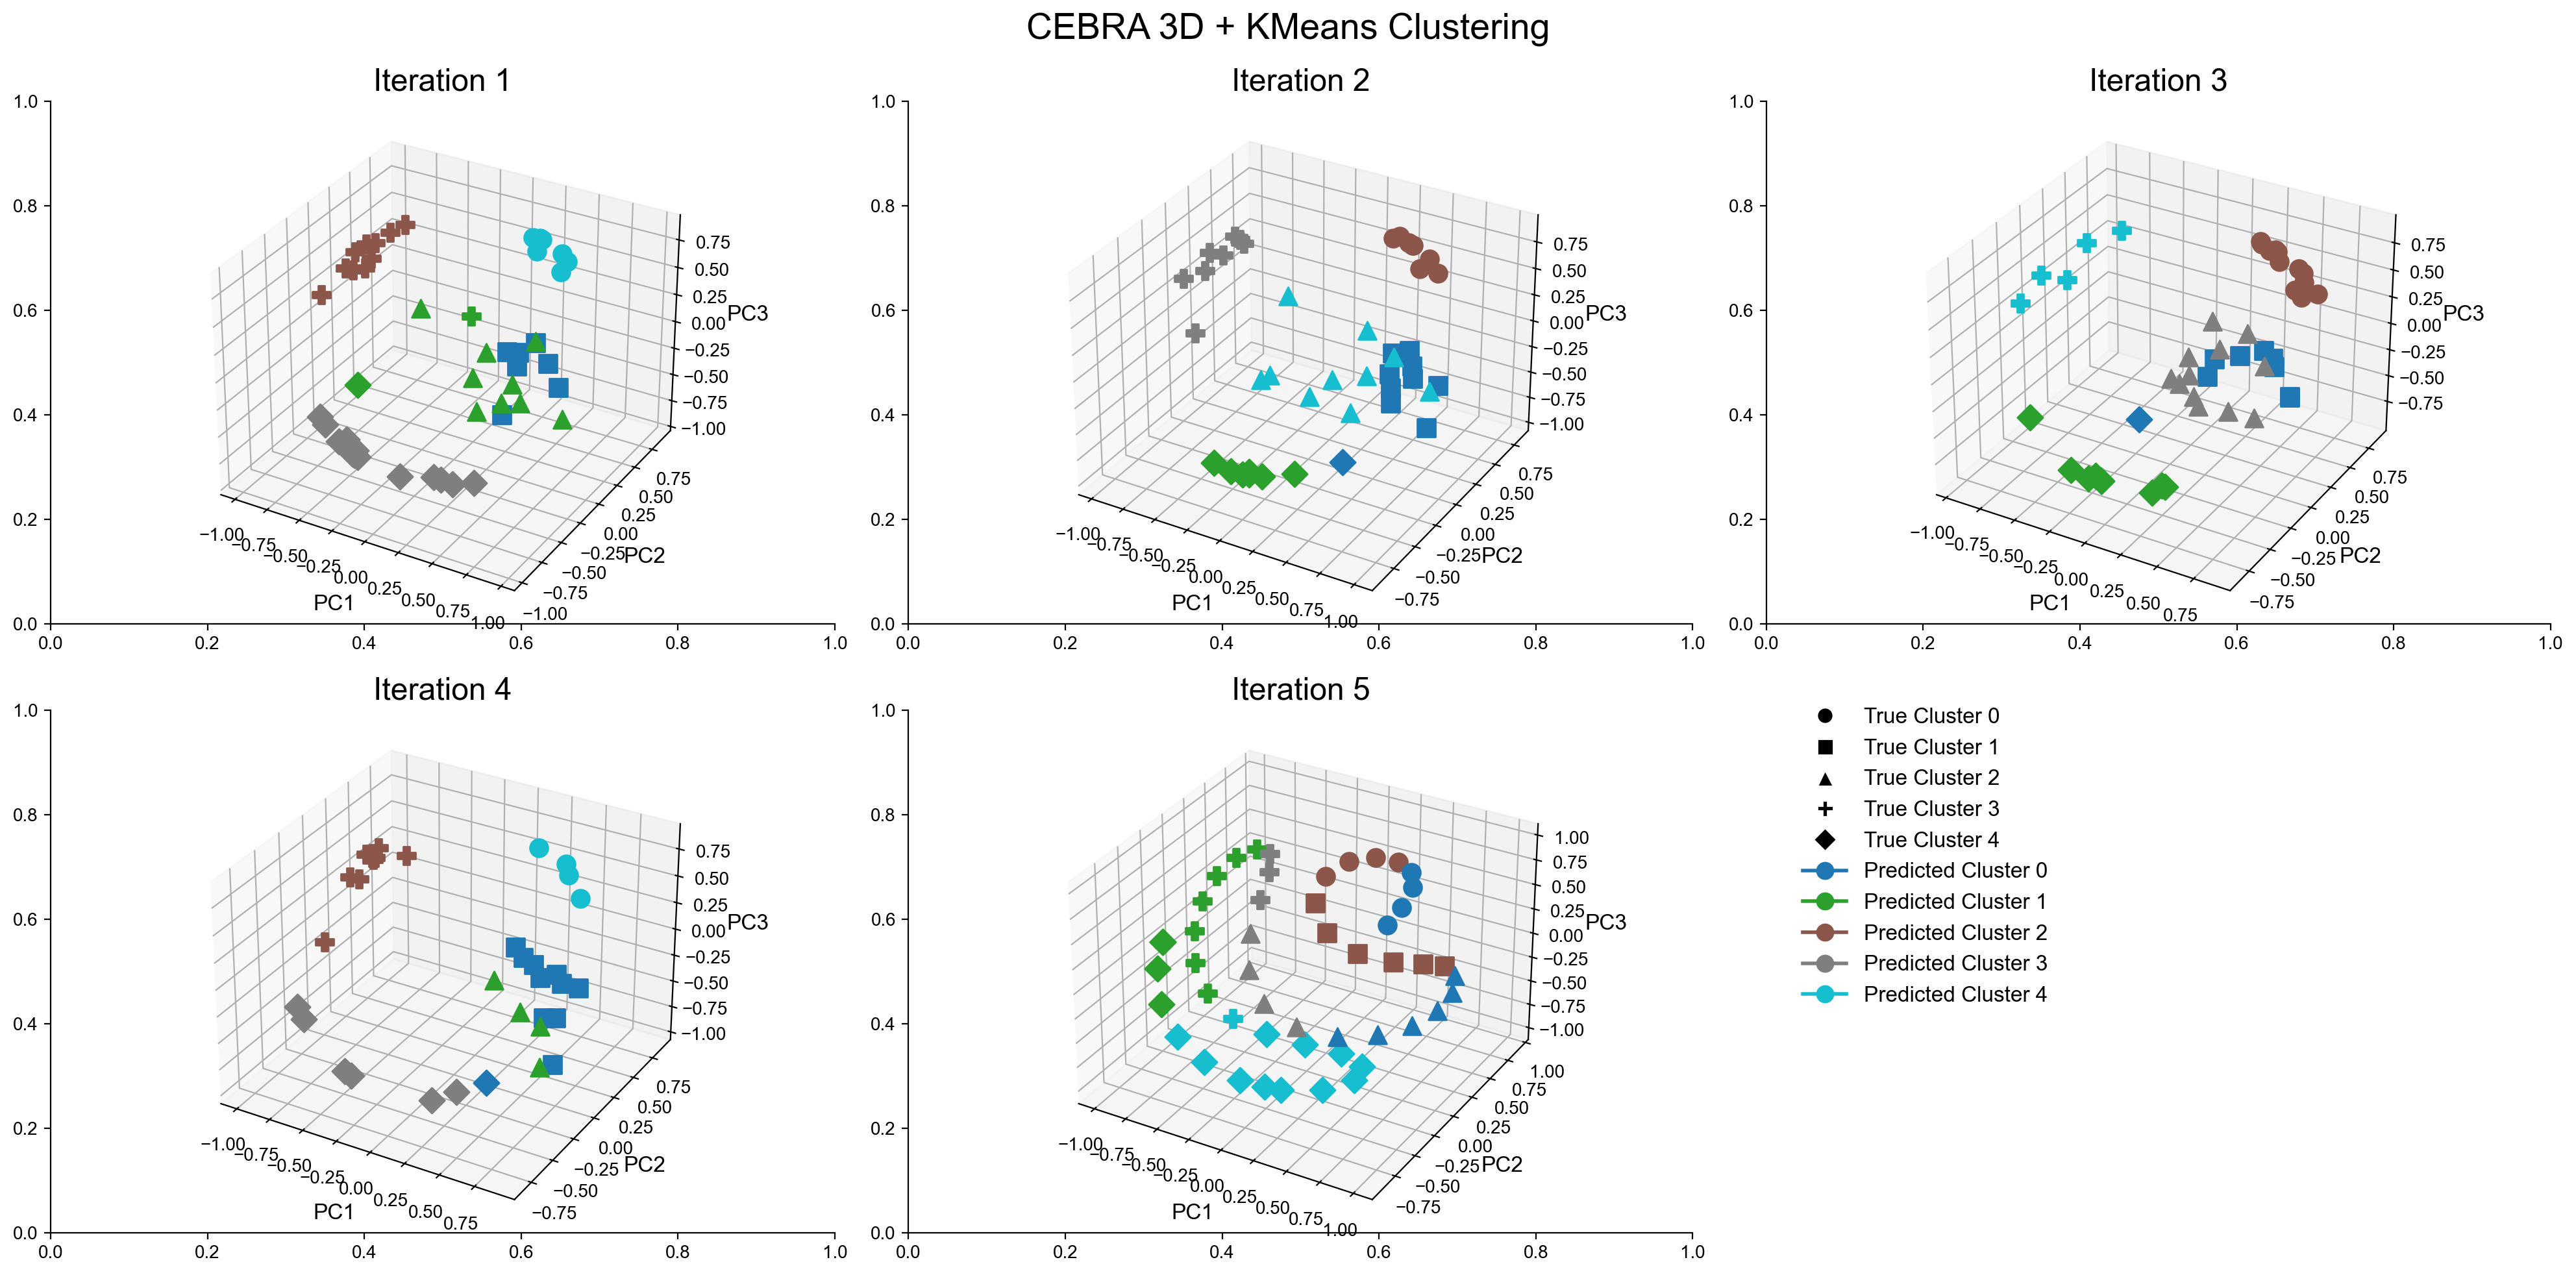

CEBRA 3D + K-Means
NMI: mean=0.8774045258473677,  std=0.12762720545681067
ARI: mean=0.8269953104434722, std=0.19221283014012694
ACC: mean=0.9049664842681258, std=0.13267944687316152


technique  nmi_mean   nmi_std  ari_mean   ari_std  acc_mean  \
0             KMeans  0.637068  0.049936  0.413983  0.067254  0.594929   
1   PCA(2D) + KMeans  0.646368  0.053653  0.433446  0.067632  0.606944   
2   PCA(5D) + KMeans  0.650803  0.022447  0.401231  0.029977  0.598266   
3  PCA(10D) + KMeans  0.633841  0.042087  0.388871  0.036613  0.590266   
4  TSNE(2D) + KMeans  0.774141  0.106592  0.650956  0.154233  0.754072   
5  TSNE(3D) + KMeans  0.395240  0.162150  0.244213  0.176496  0.529156   
6  CEBRA 3D + KMeans  0.877405  0.127627  0.826995  0.192213  0.904966   

    acc_std  
0  0.047524  
1  0.040743  
2  0.050074  
3  0.052304  
4  0.114921  
5  0.114499  
6  0.132679

In [72]:
# Load the data
datasets = os.listdir("new_data")

nmi_list = []
ari_list = []
acc_list = []

plt.figure(figsize=(20, 10))

for index, dataset in enumerate(datasets):
    data, num_clusts = torch.load(f"new_data/{dataset}")
    np.savez(f'cebra_data/{dataset[:-2]}.npz', stacked_data=data)
    data = cebra.load_data(f'cebra_data/{dataset[:-2]}.npz')
    y_true = sum([[i] * j for i, j in enumerate(num_clusts)], start=[])

    neuron_num = np.arange(0, len(data))

    # load the 3D embedding model
    loaded_cebra_model = cebra.CEBRA.load('saved_models/output_dimension_3_time_offsets_1_dataset1.pt')

    # apply the loaded 3d model to the data
    embedding_3d = loaded_cebra_model.transform(data)

    # Perform K-Means clustering
    cebra_3_kmeans = KMeans(n_clusters=5, random_state=42, n_init=300)
    cebra_3_kmeans.fit_predict(embedding_3d)

    # Evaluate the clusters
    nmi, ari, acc = eval_clusters(y_true, cebra_3_kmeans.labels_)
    nmi_list.append(nmi)
    ari_list.append(ari)
    acc_list.append(acc)

    plt.subplot(2, 3, index + 1)

    markers = ['o', 's', '^', 'P', 'D', '*']

    colors = plt.cm.get_cmap("tab10", len(np.unique(y_true)))

    true_cluster_legend = [Line2D([0], [0], marker=markers[i], color='w',
                                markerfacecolor='black', label=f'True Cluster {i}')
                        for i in range(len(np.unique(y_true)))]
    predicted_cluster_legend = [Line2D([0], [0], marker='o', color=colors(i),
                                    label=f'Predicted Cluster {i}')
                            for i in range(5)]
    legend_elements = true_cluster_legend + predicted_cluster_legend

    # Plot each data point in the 3D embedding

    ax = plt.subplot(2, 3, index + 1, projection='3d')

    for i in range(len(embedding_3d)):
        ax.scatter(embedding_3d[i, 0], embedding_3d[i, 1], embedding_3d[i, 2],
                    color=colors(cebra_3_kmeans.labels_[i]),
                    marker=markers[y_true[i]],
                    s=100,
                    alpha=1)
        ax.set_zlabel('PC3')
        ax.set_ylabel('PC2')
        ax.set_xlabel('PC1')

    plt.title(f'Iteration {index + 1}')    

plt.suptitle('CEBRA 3D + KMeans Clustering', fontsize=20)
plt.tight_layout()
plt.figlegend(handles=legend_elements, loc='lower right', bbox_to_anchor=(0.8, 0.2))
plt.savefig('figures/cebra3_kmeans_scatter.png', dpi = 300)
plt.savefig('figures/cebra3_kmeans_scatter.pdf', format='pdf', dpi=2000)
plt.show()


print("CEBRA 3D + K-Means")
print(f"NMI: mean={np.mean(nmi_list)},  std={np.std(nmi_list)}")
print(f"ARI: mean={np.mean(ari_list)}, std={np.std(ari_list)}")
print(f"ACC: mean={np.mean(acc_list)}, std={np.std(acc_list)}")

results.loc[6] = ['CEBRA 3D + KMeans', np.mean(nmi_list), np.std(nmi_list), np.mean(ari_list), np.std(ari_list), np.mean(acc_list), np.std(acc_list)]
results

torch.Size([48, 300])
torch.Size([43, 300])
torch.Size([48, 300])
torch.Size([34, 300])
torch.Size([50, 300])


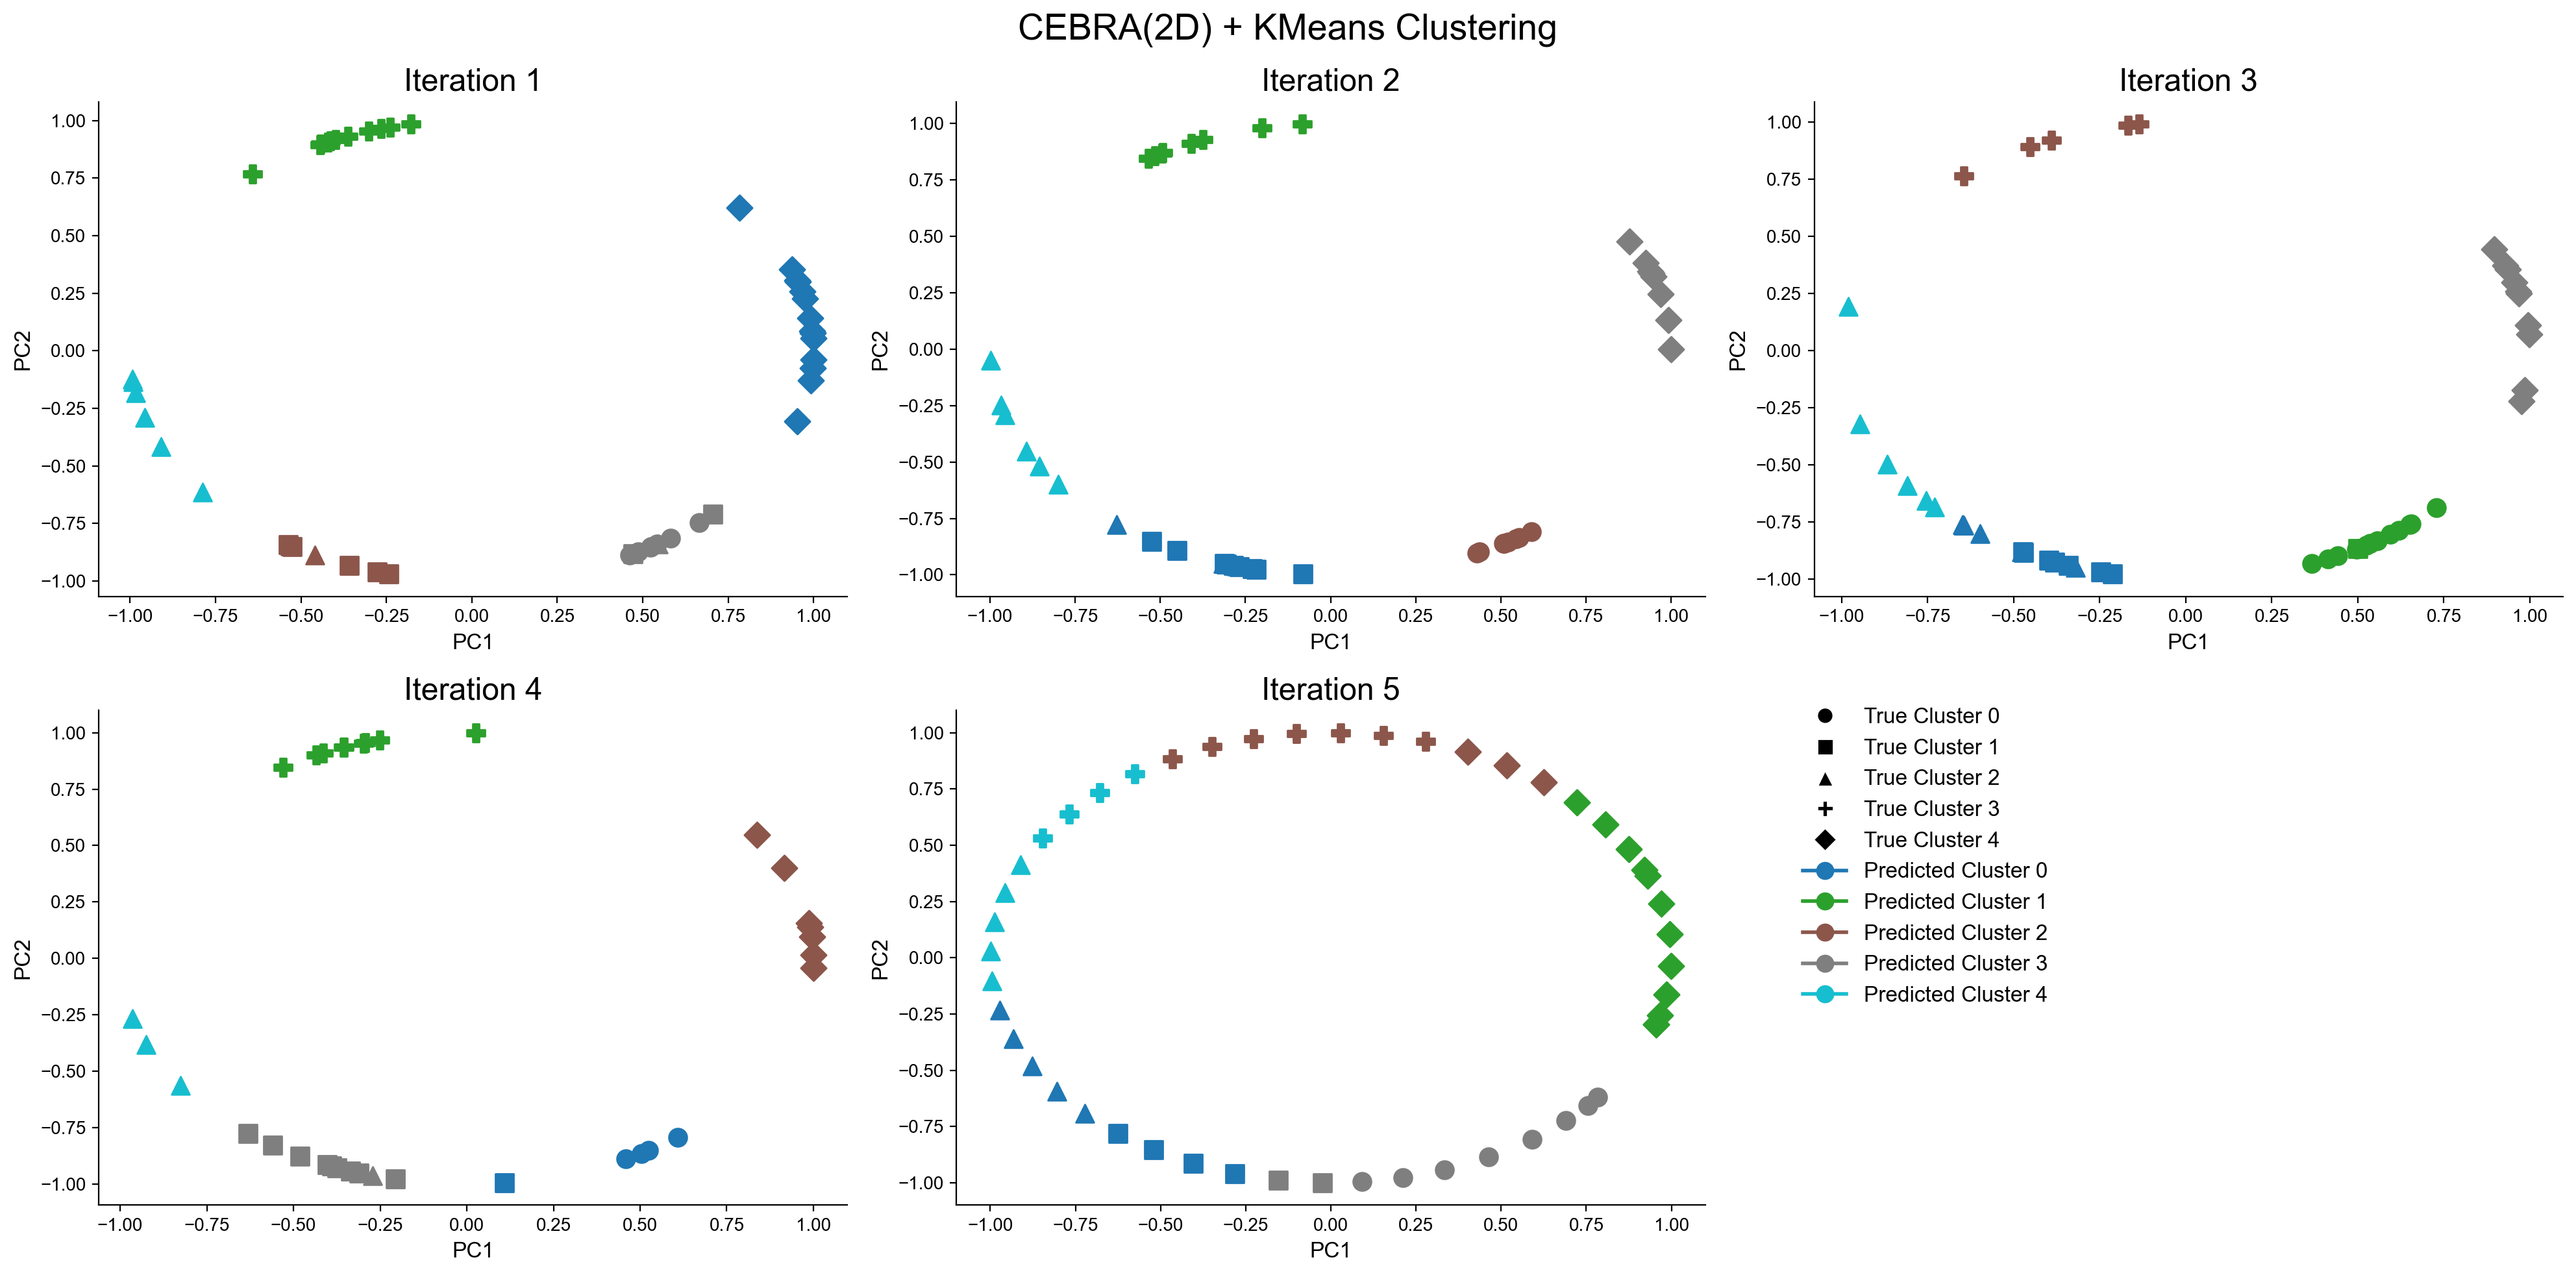

CEBRA 2D + K-Means
NMI: mean=0.8309919226562206,  std=0.07384445842172446
ARI: mean=0.7506763655857264, std=0.1106206082837479
ACC: mean=0.8636306429548564, std=0.07700465126953203


technique  nmi_mean   nmi_std  ari_mean   ari_std  acc_mean  \
0             KMeans  0.637068  0.049936  0.413983  0.067254  0.594929   
1   PCA(2D) + KMeans  0.646368  0.053653  0.433446  0.067632  0.606944   
2   PCA(5D) + KMeans  0.650803  0.022447  0.401231  0.029977  0.598266   
3  PCA(10D) + KMeans  0.633841  0.042087  0.388871  0.036613  0.590266   
4  TSNE(2D) + KMeans  0.774141  0.106592  0.650956  0.154233  0.754072   
5  TSNE(3D) + KMeans  0.395240  0.162150  0.244213  0.176496  0.529156   
6  CEBRA 3D + KMeans  0.877405  0.127627  0.826995  0.192213  0.904966   
7  CEBRA 2D + KMeans  0.830992  0.073844  0.750676  0.110621  0.863631   

    acc_std  
0  0.047524  
1  0.040743  
2  0.050074  
3  0.052304  
4  0.114921  
5  0.114499  
6  0.132679  
7  0.077005

In [73]:
# Load the data
datasets = os.listdir("new_data")

nmi_list = []
ari_list = []
acc_list = []

plt.figure(figsize=(20, 10))

for index, dataset in enumerate(datasets):
    data, num_clusts = torch.load(f"new_data/{dataset}")
    print(data.shape)
    np.savez(f'cebra_data/{dataset[:-2]}.npz', stacked_data=data)
    data = cebra.load_data(f'cebra_data/{dataset[:-2]}.npz')
    y_true = sum([[i] * j for i, j in enumerate(num_clusts)], start=[])

    neuron_num = np.arange(0, len(data))

    # load the 2D embedding model
    loaded_cebra_model = cebra.CEBRA.load('saved_models/output_dimension_2_time_offsets_1_dataset1.pt')

    # apply the loaded 2d model to the data
    embedding_2d = loaded_cebra_model.transform(data)

    # Perform K-Means clustering
    cebra_2_kmeans = KMeans(n_clusters=5, random_state=42, n_init=300)
    cebra_2_kmeans.fit_predict(embedding_2d)

    # Evaluate the clusters
    nmi, ari, acc = eval_clusters(y_true, cebra_2_kmeans.labels_)
    nmi_list.append(nmi)
    ari_list.append(ari)
    acc_list.append(acc)

    plt.subplot(2, 3, index + 1)

    markers = ['o', 's', '^', 'P', 'D', '*']

    colors = plt.cm.get_cmap("tab10", len(np.unique(y_true)))

    true_cluster_legend = [Line2D([0], [0], marker=markers[i], color='w',
                                markerfacecolor='black', label=f'True Cluster {i}')
                        for i in range(len(np.unique(y_true)))]
    predicted_cluster_legend = [Line2D([0], [0], marker='o', color=colors(i),
                                    label=f'Predicted Cluster {i}')
                            for i in range(5)]
    legend_elements = true_cluster_legend + predicted_cluster_legend

    # Plot each data point

    for i in range(len(embedding_2d)):
        plt.scatter(embedding_2d[i, 0], embedding_2d[i, 1],
                    color=colors(cebra_2_kmeans.labels_[i]),
                    marker=markers[y_true[i]],
                    s=100,
                    alpha=1)
        plt.ylabel('PC2')
        plt.xlabel('PC1')

    plt.title(f'Iteration {index + 1}')  


plt.suptitle('CEBRA(2D) + KMeans Clustering', fontsize=20)
plt.tight_layout()
plt.figlegend(handles=legend_elements, loc='lower right', bbox_to_anchor=(0.8, 0.2))
plt.savefig('figures/cebra2_kmeans_scatter.png', dpi = 300)
plt.savefig('figures/cebra2_kmeans_scatter.pdf', format='pdf', dpi=2000)
plt.show()

print("CEBRA 2D + K-Means")
print(f"NMI: mean={np.mean(nmi_list)},  std={np.std(nmi_list)}")
print(f"ARI: mean={np.mean(ari_list)}, std={np.std(ari_list)}")
print(f"ACC: mean={np.mean(acc_list)}, std={np.std(acc_list)}")

results.loc[7] = ['CEBRA 2D + KMeans', np.mean(nmi_list), np.std(nmi_list), np.mean(ari_list), np.std(ari_list), np.mean(acc_list), np.std(acc_list)]
results

# FEU Pipeline

We run the FEU pipeline on the datasets outside the notebook and load the results

In [6]:
# define the datasets
datasets = [1231, 1232, 1233, 1234, 1235]

In [7]:
def ids_to_coo(ids):
    coo = np.zeros((len(ids), len(ids)))
    for u in np.unique(ids):
        mask = ids == u
        coo[np.ix_(mask, mask)] = 1
    return coo

/var/folders/dg/s9j217g94sn98zdtwqj5cdlxnz5648/T/ipykernel_59147/3120572430.py:84: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axin.scatter(average_params[:, 1], average_params[:, 0], c = colors(3))
/var/folders/dg/s9j217g94sn98zdtwqj5cdlxnz5648/T/ipykernel_59147/3120572430.py:99: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axin.scatter(average_params[:, 1], average_params[:, 0], c = colors(0))
/var/folders/dg/s9j217g94s

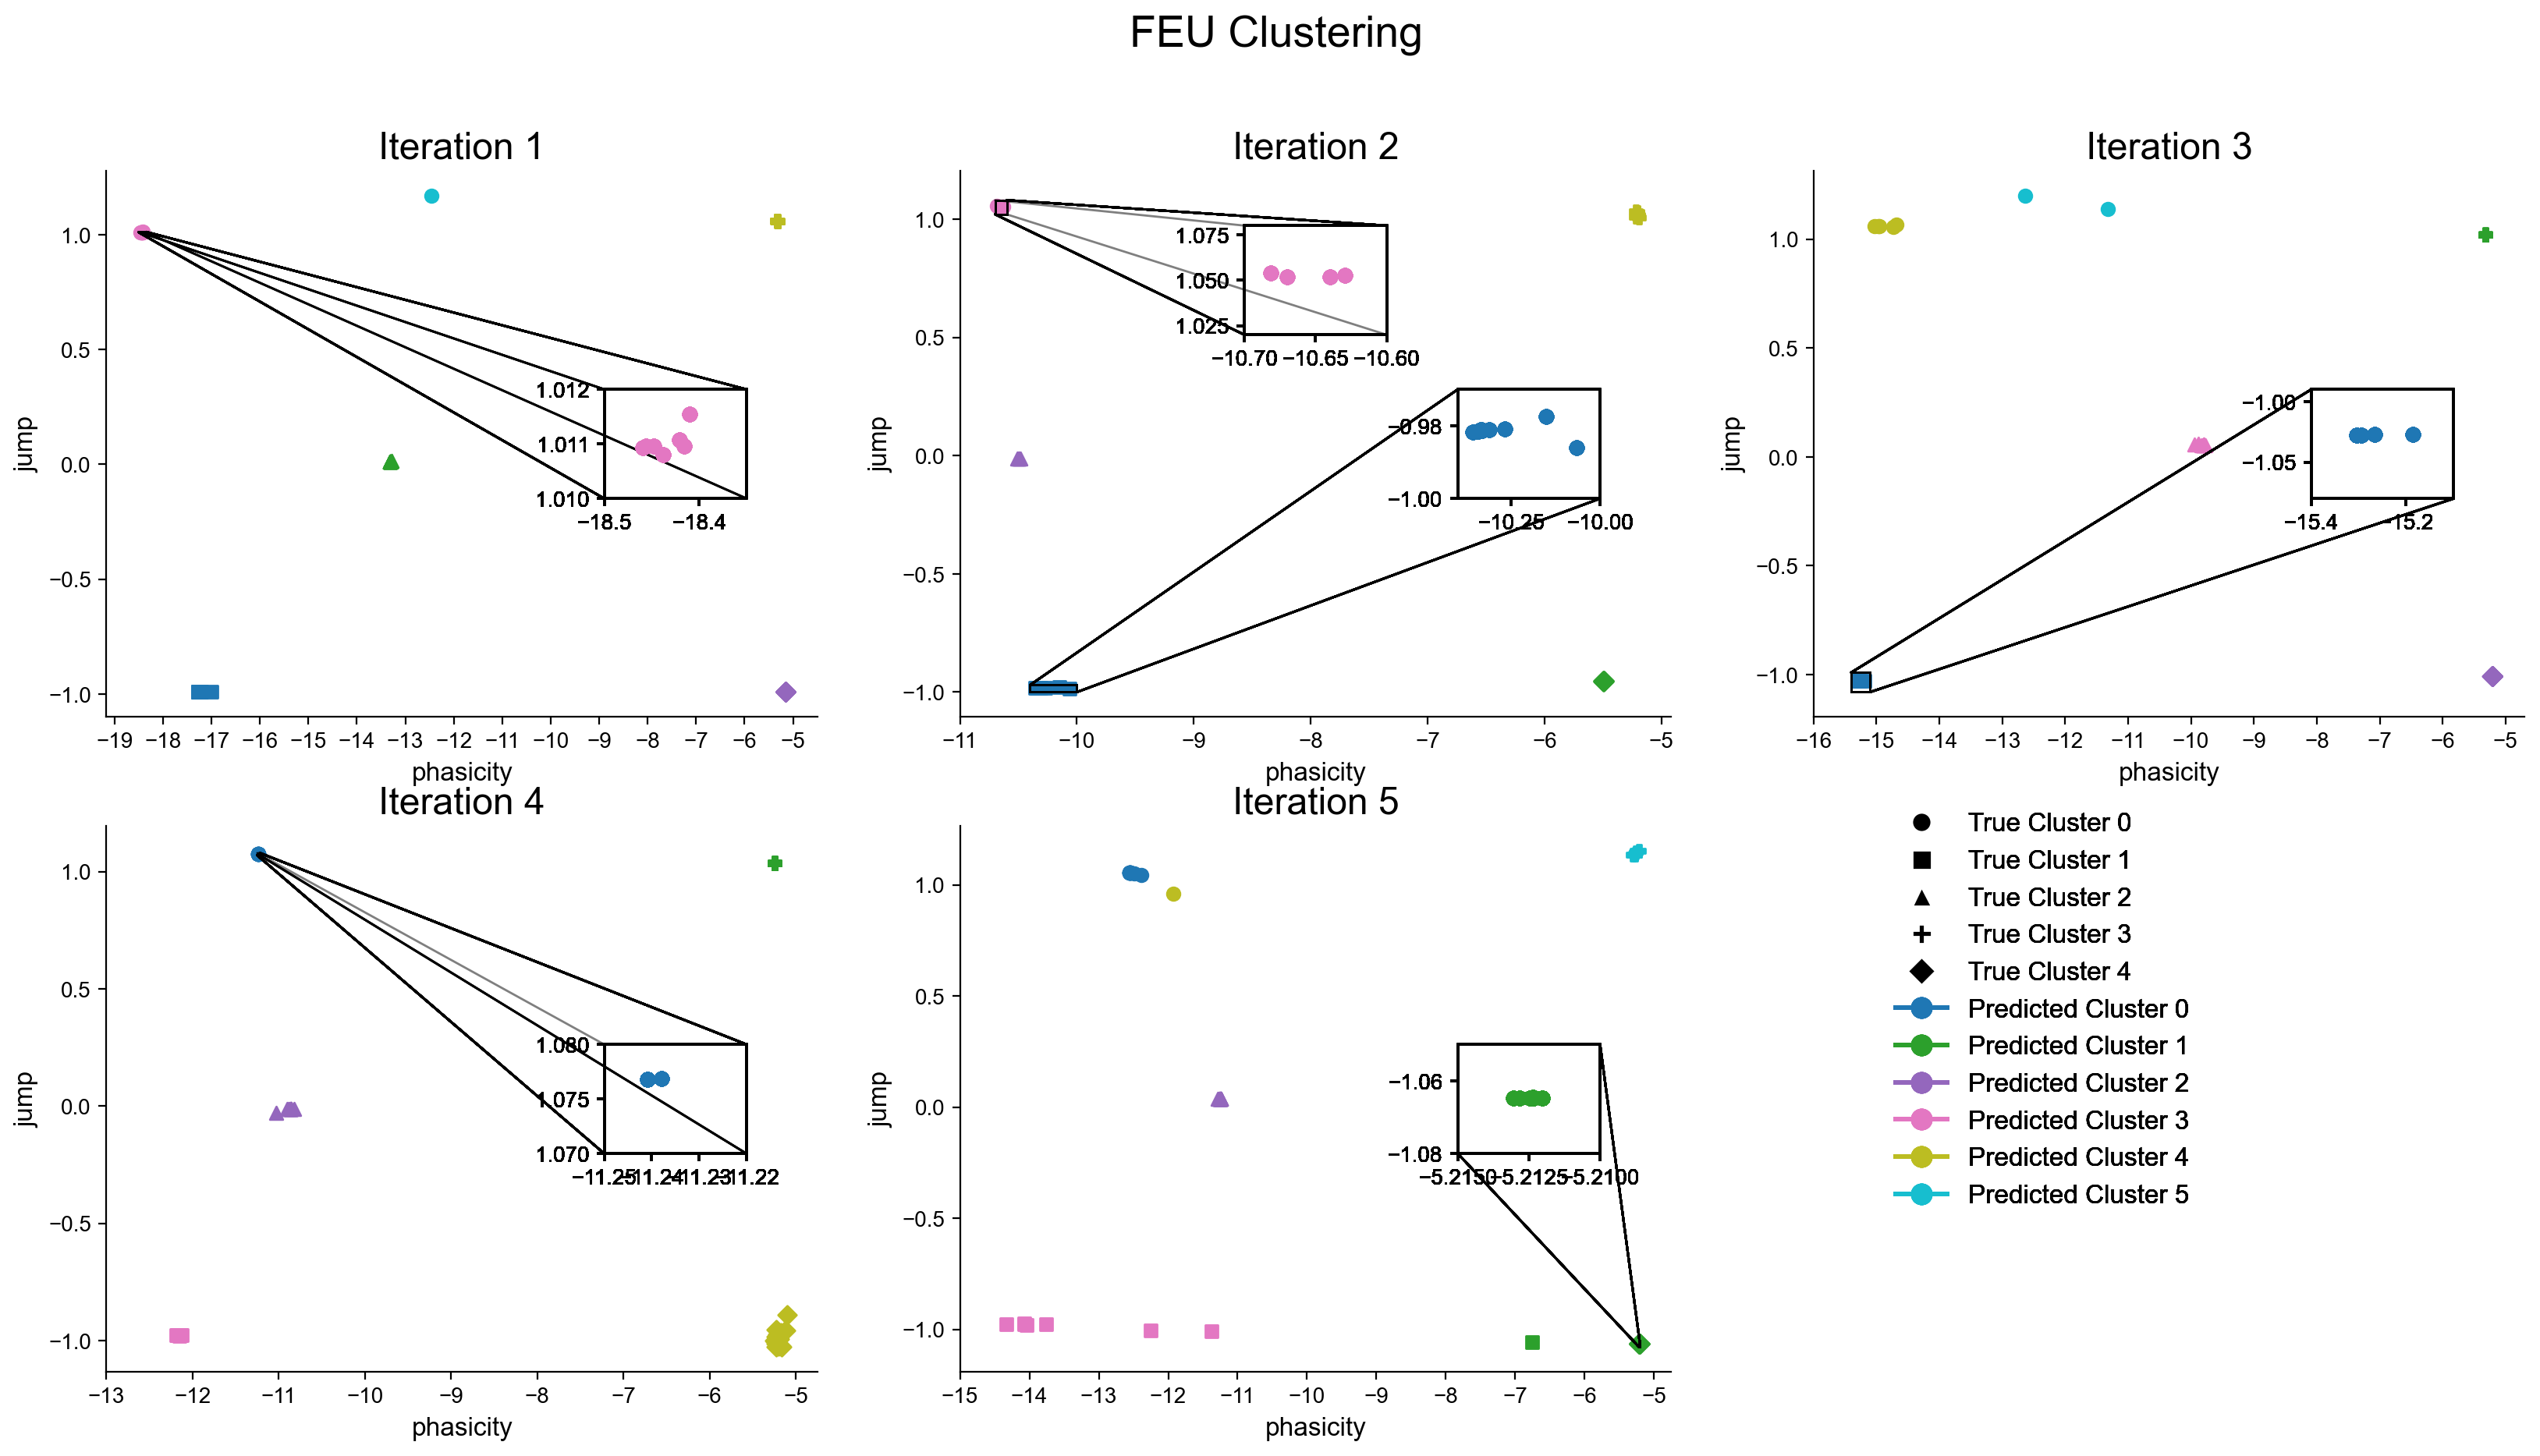

In [19]:
plt.figure(figsize=(20, 10))

dir = '../../../feu-with1231/'
for i, data in enumerate(datasets):
    assigns = pd.read_csv(f'{dir}/sim{data}_assigns.csv', header=None).iloc[500:].reset_index(drop=True)
    params = pd.read_csv(f'{dir}/sim{data}_params.tsv', header=None, sep='\t', on_bad_lines='warn', names=np.arange(0, 9)).iloc[500:].reset_index(drop=True)
    params.fillna('0,0', inplace=True)
    split_params = params.applymap(lambda x: np.array(x.split(','), dtype=float))

    average_params = []

    for count, datapoint in enumerate(assigns):
        datapoint_params = []

        for index, assignments in enumerate(assigns[datapoint]):
            datapoint_params.append(split_params[assignments].iloc[index])
    
        # convert to numpy array for efficient array indexing
        datapoint_params = np.array(datapoint_params)

        # find average jump and average phasicity for current data point
        average_jump = np.mean(datapoint_params[:, 0])
        average_phasicity = np.mean(datapoint_params[:, 1])

        # final average parameter for data point
        final_datapoint_param_average = [average_jump, average_phasicity]

        # append to list of average parameters for all data points
        average_params.append(final_datapoint_param_average)

    average_params = np.array(average_params)

    data, num_clusts = torch.load(f'{dir}/sim{data}_true.p')
    y_true = sum([[i] * j for i, j in enumerate(num_clusts)], start=[])
    
    ax = plt.subplot(2, 3, i + 1)

    # assigned clusters
    coos = np.stack([ids_to_coo(x) for _, x in assigns.iterrows()])
    mean_coo = coos.mean(axis=0)
    dists = np.linalg.norm(coos - mean_coo, axis=(1, 2))
    min_dist_idx = np.argmin(dists)
    match_idxs = np.where(np.all(coos ==[min_dist_idx], axis=(1, 2)))[0]
    reorder = assigns.loc[min_dist_idx].sort_values().index
    counts = np.bincount(assigns.loc[min_dist_idx])

    # print(counts)
    
    markers = ['o', 's', '^', 'P', 'D', '*']
    colors = plt.cm.get_cmap("tab10", 6)

    true_cluster_legend = [Line2D([0], [0], marker=markers[i], color='w',
                                markerfacecolor='black', label=f'True Cluster {i}')
                        for i in range(len(np.unique(y_true)))]
    predicted_cluster_legend = [Line2D([0], [0], marker='o', color=colors(i),
                                    label=f'Predicted Cluster {i}')
                            for i in range(6)]
    legend_elements = true_cluster_legend + predicted_cluster_legend

    # print(np.unique(assigns.loc[min_dist_idx], return_counts=True))
    # print(np.unique(y_true, return_counts=True))
        
    for ii in range(len(average_params)):
        ax.scatter(average_params[ii, 1], average_params[ii, 0], 
                    color=colors(assigns.loc[min_dist_idx][ii]),
                    marker=markers[y_true[ii]],
        )
        

        ax.set_xticks(np.arange(math.floor(min(average_params[:, 1])), math.ceil(max(average_params[:, 1])) + 1, 1))



        if i == 0:
            axin = ax.inset_axes([0.7, 0.4, 0.2, 0.2],
                     xlim=(-18.5, -18.35),
                     ylim=(1.01, 1.012)
                     )
            
            # Plot the data on the inset axis and zoom in on the important part
            axin.scatter(average_params[:, 1], average_params[:, 0], c = colors(3))

            axin.spines['top'].set_visible(True)
            axin.spines['right'].set_visible(True)

            # Add the lines to indicate where the inset axis is coming from
            ax.indicate_inset_zoom(axin, edgecolor='black')

        if i == 1:
            axin = ax.inset_axes([0.7, 0.4, 0.2, 0.2],
                     xlim=(-10.4, -10.0),
                     ylim=(-1.0, -0.97)
                     )
            
            # Plot the data on the inset axis and zoom in on the important part
            axin.scatter(average_params[:, 1], average_params[:, 0], c = colors(0))

            axin.spines['top'].set_visible(True)
            axin.spines['right'].set_visible(True)

            # Add the lines to indicate where the inset axis is coming from
            ax.indicate_inset_zoom(axin, edgecolor='black')

        if i == 1:
            axin = ax.inset_axes([0.4, 0.7, 0.2, 0.2],
                     xlim=(-10.7, -10.6),
                     ylim=(1.02, 1.08)
                     )
            
            # Plot the data on the inset axis and zoom in on the important part
            axin.scatter(average_params[:, 1], average_params[:, 0], c = colors(3))

            axin.spines['top'].set_visible(True)
            axin.spines['right'].set_visible(True)

            # Add the lines to indicate where the inset axis is coming from
            ax.indicate_inset_zoom(axin, edgecolor='black')
            
        if i == 2:
            axin = ax.inset_axes([0.7, 0.4, 0.2, 0.2],
                     xlim=(-15.4, -15.1),
                     ylim=(-1.08, -0.99)
                     )
            
            # Plot the data on the inset axis and zoom in on the important part
            axin.scatter(average_params[:, 1], average_params[:, 0], c = colors(0))

            axin.spines['top'].set_visible(True)
            axin.spines['right'].set_visible(True)

            # Add the lines to indicate where the inset axis is coming from
            ax.indicate_inset_zoom(axin, edgecolor='black')

        if i == 3: 
            axin = ax.inset_axes([0.7, 0.4, 0.2, 0.2],
                     xlim=(-11.25, -11.22),
                     ylim=(1.07, 1.08)
                     )
            
            # Plot the data on the inset axis and zoom in on the important part
            axin.scatter(average_params[:, 1], average_params[:, 0], c = colors(0))

            axin.spines['top'].set_visible(True)
            axin.spines['right'].set_visible(True)

            # Add the lines to indicate where the inset axis is coming from
            ax.indicate_inset_zoom(axin, edgecolor='black')

        if i == 4:
            axin = ax.inset_axes([0.7, 0.4, 0.2, 0.2],
                     xlim=(-5.215, -5.21),
                     ylim=(-1.08, -1.05)
                     )
            
            # Plot the data on the inset axis and zoom in on the important part
            axin.scatter(average_params[:, 1], average_params[:, 0], c = colors(1))

            axin.spines['top'].set_visible(True)
            axin.spines['right'].set_visible(True)

            # Add the lines to indicate where the inset axis is coming from
            ax.indicate_inset_zoom(axin, edgecolor='black')

    plt.ylabel('jump')
    plt.xlabel('phasicity')
    # plt.tight_layout()
    plt.figlegend(handles=legend_elements, loc='lower right', bbox_to_anchor=(0.8, 0.2))
    plt.suptitle("FEU Clustering", fontsize=20)
    plt.title(f'Iteration {i + 1}')  

plt.savefig('figures/feu_scatter.png', dpi = 300)
plt.savefig('figures/feu_scatter.pdf', format='pdf', dpi=2000)
plt.show()

In [58]:
results.to_csv('results.csv', index=False)